## Import

In [1]:
%matplotlib inline
import pandas as pd
import sqlite3
import os
import sys
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt

## Extract

In [2]:
# Define folder paths
input_folder = "input"
output_folder = "output"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Define file paths
file_fh = os.path.join(input_folder, "abschluesse_FH.csv")
file_hs = os.path.join(input_folder, "abschluesse_HS.csv")
file_fh_appendix = os.path.join(input_folder, "abschluesse-FH-APPENDIX.xls")
file_hs_appendix = os.path.join(input_folder, "abschluesse-HS-APPENDIX.xls")

# Check if files exist
missing_files = [file for file in [file_fh, file_hs, file_fh_appendix, file_hs_appendix] if not os.path.exists(file)]
if missing_files:
    print(f"❌ Fehlende Dateien: {', '.join(missing_files)}")
    sys.exit(1)  # Exit script if files are missing

# Load CSV files
df_fh = pd.read_csv(file_fh, sep=';')
df_hs = pd.read_csv(file_hs, sep=';')

print(df_fh.columns)  # Should correctly display ['PERIOD', 'UNI', 'FIELD', 'LEVEL', 'SEX', 'VALUE']

# Load additional information from Excel files
appendix_fh = pd.read_excel(file_fh_appendix, sheet_name=None)
appendix_hs = pd.read_excel(file_hs_appendix, sheet_name=None)

print("✅ Daten erfolgreich geladen!")

print("Before splitting:")
print(df_fh.dtypes)

Index(['PERIOD', 'UNI', 'FIELD', 'LEVEL', 'SEX', 'VALUE'], dtype='object')
✅ Daten erfolgreich geladen!
Before splitting:
PERIOD     object
UNI       float64
FIELD     float64
LEVEL     float64
SEX       float64
VALUE     float64
dtype: object


## Data cleansing / Transform - Profiling report

In [3]:
# Check if PERIOD contains comma-separated values (only apply .str.split() if needed)
if df_fh['PERIOD'].astype(str).str.contains(',').any():
    df_fh[['PERIOD', 'UNI', 'FIELD', 'LEVEL', 'SEX', 'VALUE']] = df_fh['PERIOD'].str.split(',', expand=True)
    df_hs[['PERIOD', 'UNI', 'FIELD', 'LEVEL', 'SEX', 'VALUE']] = df_hs['PERIOD'].str.split(',', expand=True)

# Convert columns to integers after ensuring correct format
columns_to_clean = ['PERIOD', 'UNI', 'FIELD', 'LEVEL', 'SEX', 'VALUE']

for col in columns_to_clean:
    if df_fh[col].dtype == object:
        df_fh[col] = df_fh[col].str.replace('"', '', regex=True)
    if df_hs[col].dtype == object:
        df_hs[col] = df_hs[col].str.replace('"', '', regex=True)

    df_fh[col] = df_fh[col].astype(int)
    df_hs[col] = df_hs[col].astype(int)
    
#profiling reports
# FH Profiling Report
fh_report = ProfileReport(df_fh, title="FH Profiling Report")
report_path_fh = os.path.join(output_folder, 'FH_Profiling_Report.html')
fh_report.to_file(report_path_fh)

# HS Profiling Report
hs_report = ProfileReport(df_hs, title="HS Profiling Report")
report_path_hs = os.path.join(output_folder, 'HS_Profiling_Report.html')
hs_report.to_file(report_path_hs)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Load

In [4]:
# --- Hauptskript: Datenverarbeitung und Datenbankintegration ---
# 1. Laden von FH- und HS-Abschlussdaten aus CSV- und Excel-Dateien.
# 2. Datenbereinigung und -transformation (Formatierung, Typkonvertierung).
# 3. Erstellung eines Datenbankschemas (SQLite) mit Tabellen für Perioden, Hochschultypen,
#    Universitäten, Fachbereiche, Abschlussebenen, Geschlecht und die Abschlussdaten selbst.
#    - Verwendung von Fremdschlüsseln zur Gewährleistung der Datenintegrität.
# 4. Füllen der Stammdaten-Tabellen (UniversityType, Level, Level_Mapping, Field_FH, Field_HS,
#    Field_Mapping, Period, Gender, University_FH, University_HS, University_Mapping).
# 5. Einfügen der eigentlichen Abschlussdaten in die Graduations-Tabelle.
#    - Fehlerbehandlung beim Einfügen, mit detaillierten Fehlermeldungen.
# 6. Überprüfung auf fehlende Eingabedateien
# 7. Bestätigungsmeldungen für erfolgreiche Operationen.

# Setup Sqlite Datenbank + Tabellen Schema

# Database path
db_path = os.path.join(output_folder, "abschluesse.db")

# Connect to SQLite database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Enable FOREIGN KEYS
cursor.execute("PRAGMA foreign_keys = ON;")

# Create table structure
cursor.executescript('''
CREATE TABLE IF NOT EXISTS Period (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    year INTEGER UNIQUE
);

CREATE TABLE IF NOT EXISTS University_FH (  -- Table for FH universities
    id INTEGER PRIMARY KEY,
    name TEXT NOT NULL
);

CREATE TABLE IF NOT EXISTS University_HS (  -- Table for HS universities
    id INTEGER PRIMARY KEY,
    name TEXT NOT NULL
);

CREATE TABLE IF NOT EXISTS UniversityType (
    id INTEGER PRIMARY KEY,
    name TEXT NOT NULL
);

CREATE TABLE IF NOT EXISTS University_Mapping (  -- Mapping table with its own primary key
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    university_type_id INTEGER NOT NULL,
    fh_id INTEGER,  -- ID for FH university
    hs_id INTEGER,  -- ID for HS university
    FOREIGN KEY (university_type_id) REFERENCES UniversityType(id),
    FOREIGN KEY (fh_id) REFERENCES University_FH(id),
    FOREIGN KEY (hs_id) REFERENCES University_HS(id)
);

CREATE TABLE IF NOT EXISTS Field_FH (
    id INTEGER PRIMARY KEY,
    name TEXT UNIQUE
);

CREATE TABLE IF NOT EXISTS Field_HS (
    id INTEGER PRIMARY KEY,
    name TEXT UNIQUE
);

CREATE TABLE IF NOT EXISTS Field_Mapping (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    fh_id INTEGER,
    hs_id INTEGER,
    FOREIGN KEY (fh_id) REFERENCES Field_FH (id),
    FOREIGN KEY (hs_id) REFERENCES Field_HS (id)
);

CREATE TABLE IF NOT EXISTS Level (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT UNIQUE
);

CREATE TABLE IF NOT EXISTS Level_Mapping (
    level_id INTEGER,
    fh_code INTEGER,
    hs_code INTEGER,
    FOREIGN KEY (level_id) REFERENCES Level (id)
);

CREATE TABLE IF NOT EXISTS Gender (
    id INTEGER PRIMARY KEY,
    name TEXT UNIQUE
);

CREATE TABLE IF NOT EXISTS Graduations (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    period_id INTEGER,
    university_mapping_id INTEGER,
    university_type_id INTEGER,
    field_id INTEGER,
    level_id INTEGER,
    gender_id INTEGER,
    value INTEGER,
    FOREIGN KEY (period_id) REFERENCES Period (id),
    FOREIGN KEY (gender_id) REFERENCES Gender (id),
    FOREIGN KEY (level_id) REFERENCES Level (id),
    FOREIGN KEY (university_type_id) REFERENCES UniversityType (id),
    FOREIGN KEY (field_id) REFERENCES Field_Mapping (id),
    FOREIGN KEY (university_mapping_id) REFERENCES University_Mapping (id)
);
''')
conn.commit()

print("✅ Datenbankstruktur erfolgreich erstellt!")


✅ Datenbankstruktur erfolgreich erstellt!


- Erstellung der Lookup-Tabellen
Period, Sex, University_FH, University_HS, Field_FH, Field_HS, Level und Level_Mapping werden aus den Appendix-Dateien gefüllt.
- Korrekte Referenzen für die Haupttabelle Graduations
IDs aus den Lookup-Tabellen (Period, Sex, University, Field, Level) werden vor dem Einfügen bestimmt.
university_type wird genutzt, um zwischen FH und HS zu unterscheiden.
- Saubere Normalisierung & keine doppelten Einträge
Die Level_Mapping-Tabelle stellt sicher, dass unterschiedliche FH- und HS-Codes korrekt referenziert werden.

In [5]:
# Datenpopulation - Referenztabellen

# Populate the UniversityType table
university_types = [
    ('FH',),
    ('HS',)
]

for name in university_types:
    cursor.execute("INSERT OR IGNORE INTO UniversityType (name) VALUES (?)", name)

conn.commit()

levels = [
    (1, "First university degree and diploma"),
    (2, "Diploma"),
    (3, "Bachelor"),
    (4, "Master"),
    (5, "Doctorate"),
    (6, "Degree of continuing education and training")
]

for level_id, name in levels:
    cursor.execute("INSERT INTO Level (id, name) VALUES (?, ?)", (level_id, name))

conn.commit()

# Populate the Level_Mapping table with the correct data
level_mappings = [
    (1, None, 1),    # Maps to HS code 1 (First university degree and diploma)
    (2, 1, None),    # Maps to FH code 1 (Diploma)
    (3, 2, 2),       # Maps to both FH code 2 and HS code 2 (Bachelor)
    (4, 3, 3),       # Maps to both FH code 3 and HS code 3 (Master)
    (5, None, 4),    # Maps to HS code 4 (Doctorate)
    (6, 4, 99)       # Maps to FH code 4 and HS code 99 (Degree of continuing education and training)
]

for level_id, fh_code, hs_code in level_mappings:
    cursor.execute("INSERT INTO Level_Mapping (level_id, fh_code, hs_code) VALUES (?, ?, ?)",
                   (level_id, fh_code, hs_code))

conn.commit()

# Define FH fields
fh_fields = [
    (1, "Architecture, Construction and Planning"),
    (2, "Engineering and IT"),
    (3, "Chemistry and Life Sciences"),
    (4, "Agriculture and Forestry"),
    (5, "Business, Management and Services"),
    (6, "Design"),
    (7, "Sport"),
    (8, "Music, Theatre and Other Arts"),
    (11, "Applied Linguistics"),
    (12, "Social Work"),
    (13, "Applied Psychology"),
    (14, "Health"),
    (15, "Teacher education"),
    (99, "Non allocable")
]

# Define HS fields
hs_fields = [
    (1, "Humanities and social Sciences"),
    (2, "Economics"),
    (3, "Law"),
    (4, "Exact and natural Sciences"),
    (5, "Medicine and Pharmacy"),
    (6, "Engineering, Architecture"),
    (7, "Interdisciplinary and Other")
]

# Insert FH fields
for field_id, name in fh_fields:
    cursor.execute("INSERT OR REPLACE INTO Field_FH (id, name) VALUES (?, ?)",
                  (field_id, name))

# Insert HS fields
for field_id, name in hs_fields:
    cursor.execute("INSERT OR REPLACE INTO Field_HS (id, name) VALUES (?, ?)",
                  (field_id, name))

conn.commit()

# Populate the Field_Mapping table with the correct data
field_mappings = [
    (1, 1, None),    # Maps to FH code 1
    (2, 2, None),    # Maps to FH code 2
    (3, 3, None),    # Maps to FH code 3
    (4, 4, None),    # Maps to FH code 4
    (5, 5, None),    # Maps to FH code 5
    (6, 6, None),    # Maps to FH code 6
    (7, 7, None),    # Maps to FH code 7
    (8, 8, None),    # Maps to FH code 8
    (9, 11, None),   # Maps to FH code 11
    (10, 12, None),   # Maps to FH code 12
    (11, 13, None),   # Maps to FH code 13
    (12, 14, None),   # Maps to FH code 14
    (13, 15, None),   # Maps to FH code 15
    (14, 99, None),   # Maps to FH code 99 (Non allocable)
    (15, None, 1),    # Maps to HS code 1
    (16, None, 2),    # Maps to HS code 2
    (17, None, 3),    # Maps to HS code 3
    (18, None, 4),    # Maps to HS code 4
    (19, None, 5),    # Maps to HS code 5
    (20, None, 6),    # Maps to HS code 6
    (21, None, 7)     # Maps to HS code 7
]

for mapping_id, fh_id, hs_id in field_mappings:
    cursor.execute(
        "INSERT OR IGNORE INTO Field_Mapping (id, fh_id, hs_id) VALUES (?, ?, ?)",
        (mapping_id, fh_id, hs_id)
    )

conn.commit()

# Ensure 'year' is stored as INTEGER
periods = pd.DataFrame({'year': pd.concat([df_fh['PERIOD'], df_hs['PERIOD']]).astype(int).unique()})

# Insert values safely as INTEGER
for year in sorted(periods['year'].astype(int).tolist()):
    cursor.execute("INSERT OR IGNORE INTO Period (year) VALUES (?)", (year,))

conn.commit()

In [6]:
# --- Datenpopulation: Gender, Universitäten und University_Mapping ---
# Füllen der Tabellen Gender, University_FH, University_HS
# und University_Mapping mit Daten.
# - Definition Hilfsfunktion get_field_id, die für das spätere Einfügen der Abschlussdaten
# benötigt wird; stellt sicher, dass korrekte IDs aus der Field_Mapping-Tabelle abgerufen
# werden und Fehlerbehandlung.

# Gender Table
gender_mapping = {0: "Unknown", 1: "Male", 2: "Female"}
for gender_id, gender_name in gender_mapping.items():
    cursor.execute("INSERT OR IGNORE INTO Gender (id, name) VALUES (?, ?)", (gender_id, gender_name))

# Populate University_FH and University_HS tables
universities_fh = appendix_fh['UNI'][['CODE', 'LABEL_EN']].copy()
universities_fh.columns = ['id', 'name']

universities_hs = appendix_hs['UNI'][['CODE', 'LABEL_EN']].copy()
universities_hs.columns = ['id', 'name']

for _, row in universities_fh.iterrows():
    cursor.execute("INSERT OR REPLACE INTO University_FH (id, name) VALUES (?, ?)",
                   (row['id'], row['name']))

for _, row in universities_hs.iterrows():
    cursor.execute("INSERT OR REPLACE INTO University_HS (id, name) VALUES (?, ?)",
                   (row['id'], row['name']))

conn.commit()

print("✅ Fields successfully inserted into DB!")

# Populate the University_Mapping table
for university_type in ['FH', 'HS']:  # Directly iterate over the university types
    universities = appendix_fh['UNI'][['CODE', 'LABEL_EN']].copy() if university_type == 'FH' else appendix_hs['UNI'][['CODE', 'LABEL_EN']].copy()
    universities.columns = ['id', 'name']
    universities['id'] = universities['id'].astype(int)

    cursor.execute("SELECT id FROM UniversityType WHERE name = ?", (university_type,))
    university_type_id = cursor.fetchone()[0]

    for _, row in universities.iterrows():
        university_id = row['id']
        university_type_id_int = university_type_id

        if university_type == 'FH':
            cursor.execute("INSERT OR REPLACE INTO University_Mapping (university_type_id, fh_id) VALUES (?, ?)",
                           (university_type_id_int, university_id))
        elif university_type == 'HS':
            cursor.execute("INSERT OR REPLACE INTO University_Mapping (university_type_id, hs_id) VALUES (?, ?)",
                           (university_type_id_int, university_id))

conn.commit()

# Check if a field code exists in the Level_Mapping table
def get_field_id(cursor, field_code, university_type):
    """
    Fetches the field_id from the Field_Mapping table, handling NULL values appropriately.

    :param cursor: The database cursor.
    :param field_code: The field code to look up.
    :param university_type: The type of university ('FH' or 'HS').
    :return: The field_id if found, otherwise raises an error.
    """
    # Determine the column to use based on university type
    column_to_use = 'fh_id' if university_type == 'FH' else 'hs_id'

    # Execute the query
    cursor.execute(f"SELECT id FROM Field_Mapping WHERE {column_to_use} = ?", (field_code,))
    result = cursor.fetchone()

    # Check if the result is None (which corresponds to NULL in the database)
    if result is None:
        raise ValueError(f"Field ID not found for {university_type} code: {field_code}")

    # Extract the actual ID value
    field_id = result[0]

    # Additional check if field_id itself is None
    if field_id is None:
        raise ValueError(f"Field ID is NULL for {university_type} code: {field_code}")

    return field_id


✅ Fields successfully inserted into DB!


In [7]:
# Fügt Abschlussdaten in die `Graduations`-Tabelle ein.
# Iteriert über den DataFrame, holt IDs aus Referenztabellen und
# fügt Datensätze in die `Graduations`-Tabelle ein.

def insert_graduations_data(dataframe, university_type):
    errors = []
    for index, row in dataframe.iterrows():
        try:
            year = int(row['PERIOD'])
            value = int(row['VALUE'])
            field_code = int(row['FIELD'])
            university_code = int(row['UNI'])

            # Get period_id
            cursor.execute("SELECT id FROM Period WHERE year = ?", (year,))
            period_id = cursor.fetchone()
            if not period_id:
                raise ValueError(f"Period ID not found for year: {year}")
            period_id = period_id[0]  # Extract integer value

            # Get university_mapping_id
            column_to_use = 'fh_id' if university_type == 'FH' else 'hs_id'
            cursor.execute(f"SELECT id FROM University_Mapping WHERE {column_to_use} = ?", (university_code,))
            university_mapping_id = cursor.fetchone()
            if not university_mapping_id:
                raise ValueError(f"University mapping ID not found for code: {university_code}")
            university_mapping_id = university_mapping_id[0]  # Extract integer value

            # Get university_type_id
            cursor.execute("SELECT id FROM UniversityType WHERE name = ?", (university_type,))
            university_type_id = cursor.fetchone()
            if not university_type_id:
                raise ValueError(f"UniversityType ID not found for {university_type}")
            university_type_id = university_type_id[0]

            # Get field_id using the helper function
            field_id = get_field_id(cursor, field_code, university_type)

            # Get level_id
            level_code = int(row['LEVEL'])
            code_field = 'fh_code' if university_type == 'FH' else 'hs_code'
            cursor.execute(f"SELECT level_id FROM Level_Mapping WHERE {code_field} = ?", (level_code,))
            level_id = cursor.fetchone()
            if not level_id:
                raise ValueError(f"Level ID not found for code: {level_code}")
            level_id = level_id[0]

            # Get gender_id
            gender_code = int(row['SEX'])
            cursor.execute("SELECT id FROM Gender WHERE id = ?", (gender_code,))
            gender_id = cursor.fetchone()
            if not gender_id:
                raise ValueError(f"Gender ID not found for code: {gender_code}")
            gender_id = gender_id[0]

            # Insert graduation record
            cursor.execute('''
                INSERT INTO Graduations (
                    period_id, university_mapping_id, university_type_id, field_id,
                    level_id, gender_id, value
                ) VALUES (?, ?, ?, ?, ?, ?, ?)
            ''', (
                period_id, university_mapping_id, university_type_id, field_id,
                level_id, gender_id, value
            ))

        except Exception as e:
            print(f"Error inserting data for row {index}: {e}")  # Print error for debugging
            errors.append(f"Error inserting data for row {index}: {str(e)}")

    if errors:
        print("\n".join(errors))
    else:
        print(f"✅ Graduation data for {university_type} successfully inserted into the database.")


# Process and insert data for both FH and HS datasets
insert_graduations_data(df_fh, 'FH')
insert_graduations_data(df_hs, 'HS')

conn.commit()
print("Data from both datasets has been successfully loaded into the database.")

✅ Graduation data for FH successfully inserted into the database.
✅ Graduation data for HS successfully inserted into the database.
Data from both datasets has been successfully loaded into the database.


## EDA

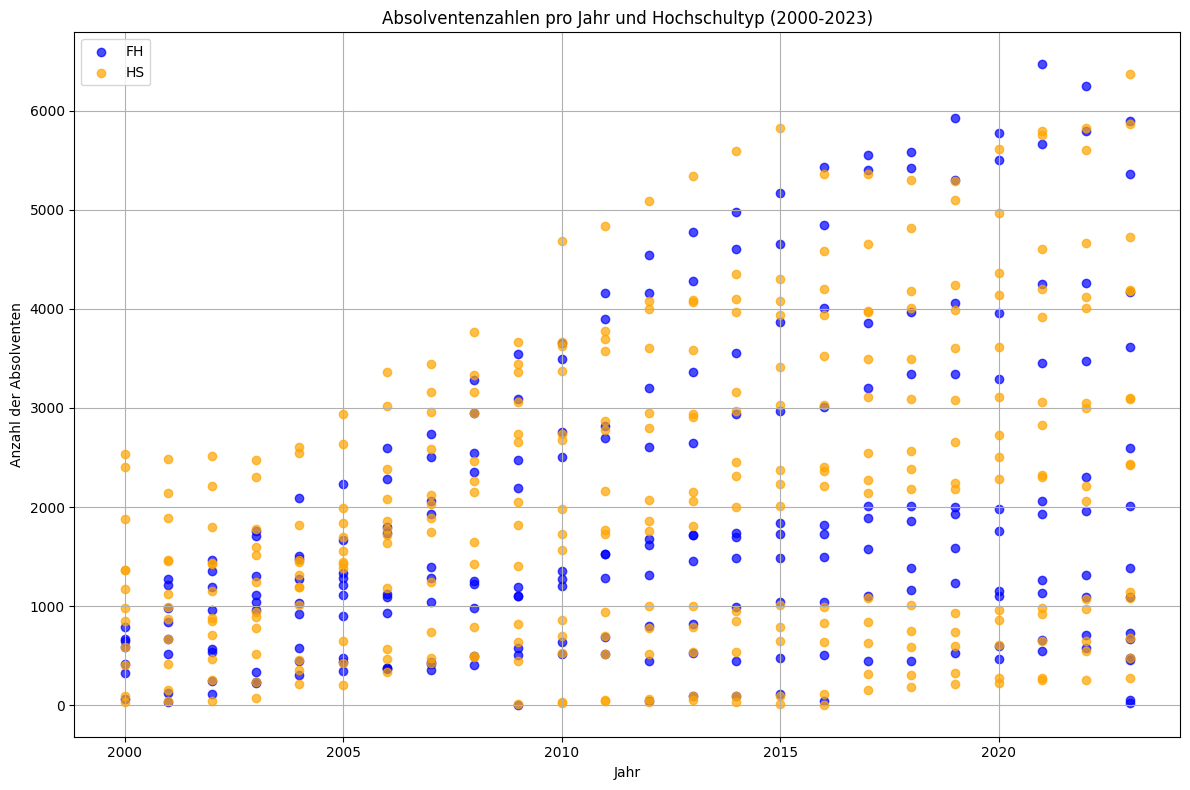

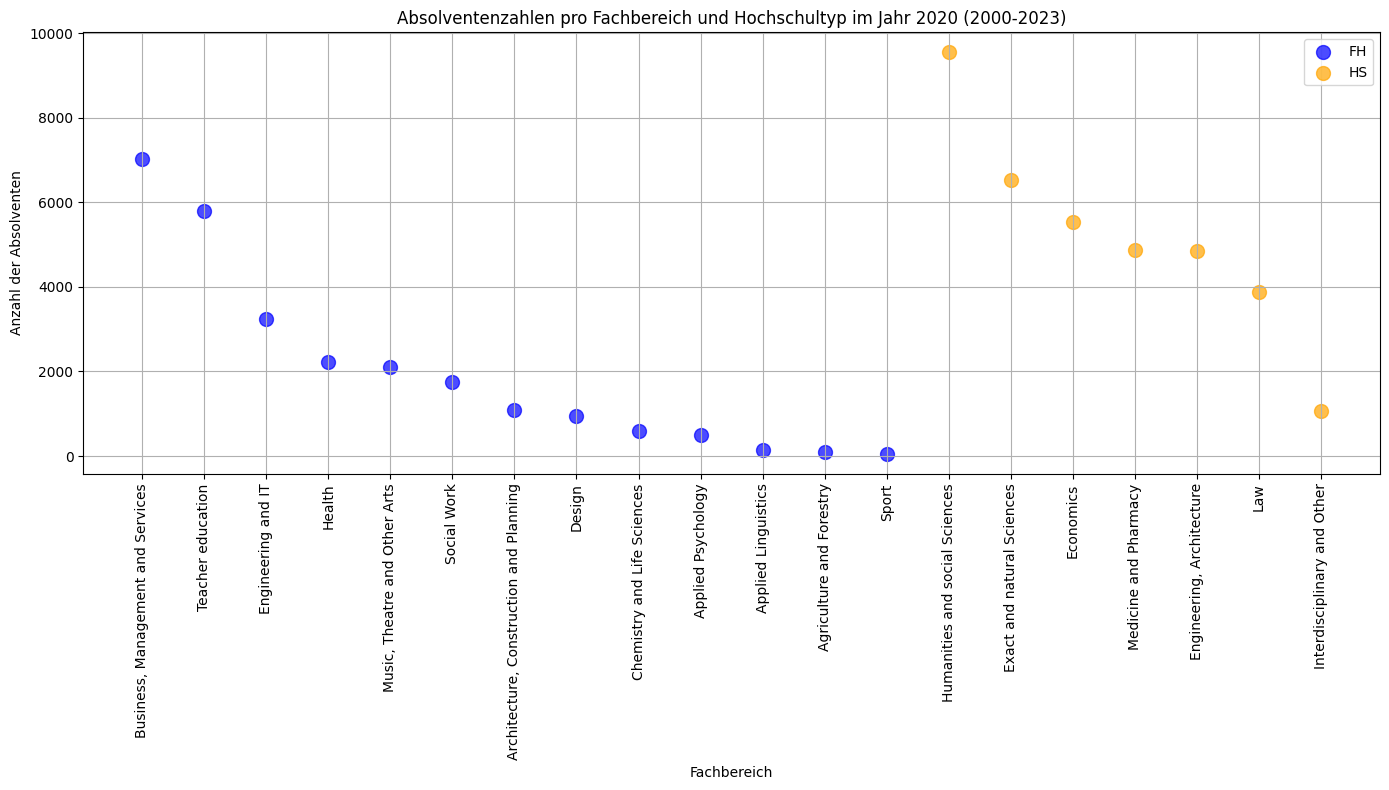

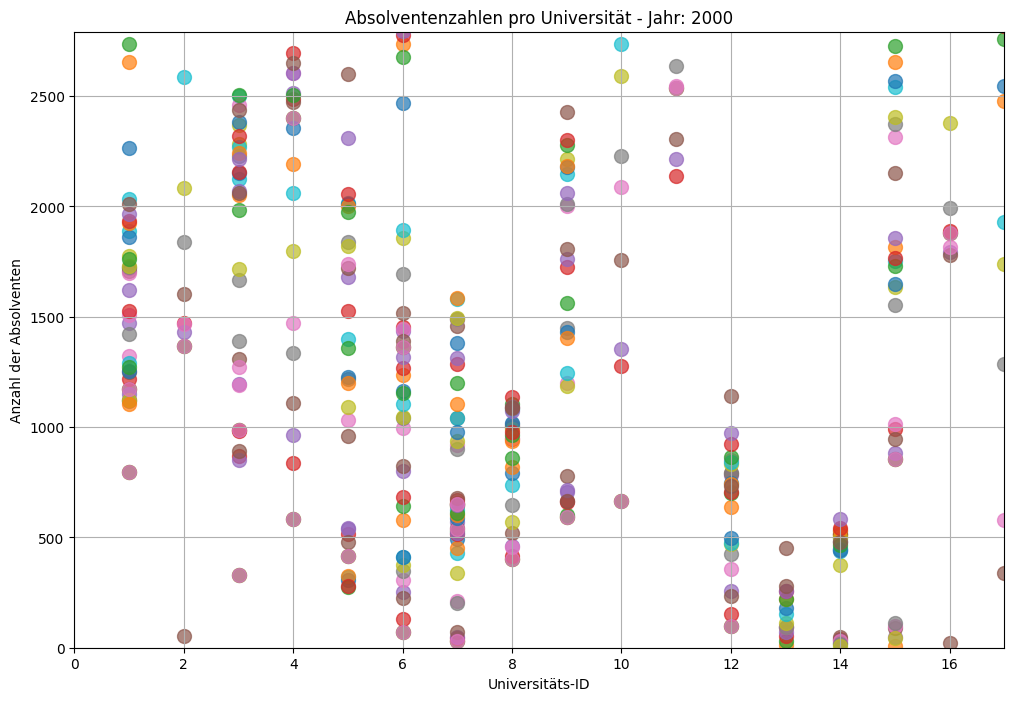

In [34]:
# Verschiedene Visualisierungen und Analysen der Daten
# 1. Scatterplot der Absolventenzahlen pro Jahr und Hochschultyp
# 2. Scatterplot der Absolventenzahlen pro Fachbereich und Hochschultyp für ein bestimmtes Jahr
# 3. Animierter Scatterplot der Absolventenzahlen pro Universität und Jahr

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Datenbankverbindung (am Anfang öffnen)
db_path = "output/abschluesse.db"  # Passe den Pfad an, falls nötig
conn = sqlite3.connect(db_path)

# --- Daten abfragen (mit Zeitraum-Einschränkung) ---
query = """
SELECT
    p.year,
    g.university_type_id,
    COALESCE(um.fh_id, um.hs_id) AS university_id,
    ut.name AS university_type,
    SUM(g.value) AS total_graduates
FROM Graduations g
JOIN Period p ON g.period_id = p.id
JOIN University_Mapping um ON g.university_mapping_id = um.id
JOIN UniversityType ut ON g.university_type_id = ut.id
WHERE p.year BETWEEN 2000 AND 2023  -- Zeitraum-Einschränkung
GROUP BY p.year, g.university_type_id, um.fh_id, um.hs_id
ORDER BY p.year, g.university_type_id, total_graduates DESC;
"""
df = pd.read_sql_query(query, conn)


# --- Scatterplot 1: Absolventenzahl vs. Zeit (mit Hochschultyp-Färbung) ---

# Farben für Hochschultypen definieren
colors = {1: 'blue', 2: 'orange'}  # 1: FH, 2: HS

plt.figure(figsize=(12, 8))

for uni_type in df['university_type_id'].unique():
    subset = df[df['university_type_id'] == uni_type]
    plt.scatter(subset['year'], subset['total_graduates'], label=f"{subset['university_type'].iloc[0]}", c=colors[uni_type], alpha=0.7)

plt.xlabel("Jahr")
plt.ylabel("Anzahl der Absolventen")
plt.title("Absolventenzahlen pro Jahr und Hochschultyp (2000-2023)")  # Titel aktualisiert
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Scatterplot 2: Absolventenzahl vs. Fachbereich (für ein bestimmtes Jahr) ---

# Wähle ein Jahr für die Analyse aus
year_to_analyze = 2020

# Daten für das ausgewählte Jahr abfragen und Fachbereichsnamen hinzufügen (mit Zeitraum-Einschränkung)
query = f"""
SELECT
    g.university_type_id,
    ut.name AS university_type,
    COALESCE(ff.name, fh.name) AS field_name,
    SUM(g.value) AS total_graduates
FROM Graduations g
JOIN Period p ON g.period_id = p.id
JOIN UniversityType ut ON g.university_type_id = ut.id
LEFT JOIN Field_Mapping fm ON g.field_id = fm.id
LEFT JOIN Field_FH ff ON fm.fh_id = ff.id
LEFT JOIN Field_HS fh ON fm.hs_id = fh.id
WHERE p.year = {year_to_analyze}  -- Jahr filtern
  AND p.year BETWEEN 2000 AND 2023    -- Zeitraum-Einschränkung
GROUP BY g.university_type_id, ut.name, ff.name, fh.name
ORDER BY g.university_type_id, total_graduates DESC;
"""

df_year = pd.read_sql_query(query, conn)


# Farben für Hochschultypen
colors = {1: 'blue', 2: 'orange'}

plt.figure(figsize=(14, 8))

for uni_type in df_year['university_type_id'].unique():
    subset = df_year[df_year['university_type_id'] == uni_type]
    plt.scatter(subset['field_name'], subset['total_graduates'], label=f"{subset['university_type'].iloc[0]}", c=colors[uni_type], s=100, alpha=0.7)

plt.xlabel("Fachbereich")
plt.ylabel("Anzahl der Absolventen")
plt.title(f"Absolventenzahlen pro Fachbereich und Hochschultyp im Jahr {year_to_analyze} (2000-2023)") # Titel aktualisiert
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Animierter Scatterplot ---

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel("Universitäts-ID")
ax.set_ylabel("Anzahl der Absolventen")
ax.set_title("Absolventenzahlen pro Universität und Jahr (Animiert, 2000-2023)") # Titel aktualisiert
ax.grid(True)

# Initialisiere einen leeren Scatterplot
scatter = ax.scatter([], [])

# Funktion, die für jeden Frame der Animation aufgerufen wird
def update(year):
    data_year = df[df['year'] == year]
    scatter = ax.scatter(data_year['university_id'], data_year['total_graduates'], alpha=0.7, s=100)

    # Achsenlimits dynamisch anpassen
    ax.set_xlim(data_year['university_id'].min()-1, data_year['university_id'].max()+1)
    ax.set_ylim(0, data_year['total_graduates'].max() * 1.1)

    ax.set_title(f"Absolventenzahlen pro Universität - Jahr: {year}")

    return scatter

# Erstelle die Animation, stelle sicher, dass nur die Jahre im gewählten bereich angezeigt werden.
ani = animation.FuncAnimation(fig, update, frames=sorted(df['year'].unique()), repeat=False) #sortiert

conn.close()  # Verbindung schließen, NACHDEM die Animation erstellt wurde.

# Zeige die Animation in Jupyter an.
HTML(ani.to_jshtml())

### 1. Gesamtanzahl Abschlüsse der universitären Hochschulen und Fachhochschulen (2000-2023)


   university_mapping_id         university_name  total_graduates
0                     29    University of Zurich           144788
1                     22    University of Geneva           123223
2                     34              ETH Zurich           119509
3                     20      University of Bern            95792
4                     10  Zürcher Fachhochschule            89144
Index(['university_mapping_id', 'university_name', 'total_graduates'], dtype='object')


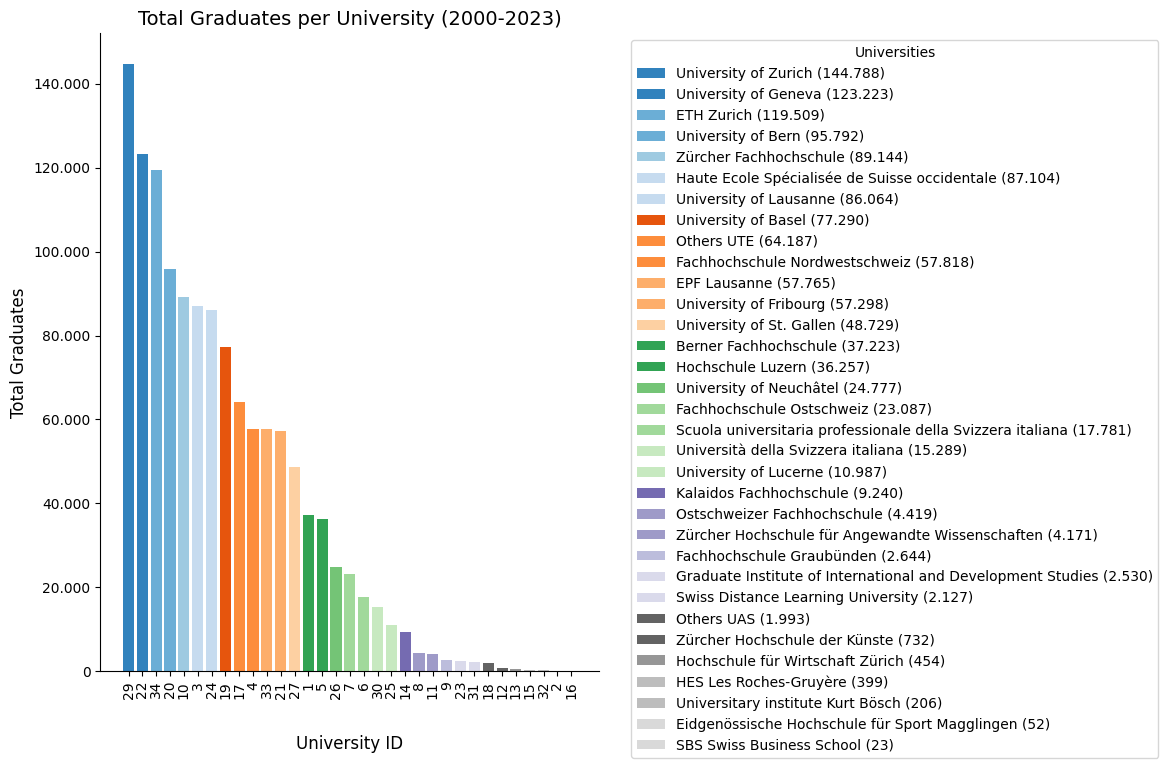

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

conn = sqlite3.connect(db_path)

# SQL query to fetch the data with university_mapping_id
query = """
SELECT
    um.id AS university_mapping_id,  -- Correct column for university ID
    CASE
        WHEN um.university_type_id = 1 THEN uf.name
        WHEN um.university_type_id = 2 THEN uh.name
    END AS university_name,
    SUM(g.value) AS total_graduates
FROM
    Graduations g
JOIN
    University_Mapping um ON g.university_mapping_id = um.id
LEFT JOIN
    University_FH uf ON uf.id = um.fh_id
LEFT JOIN
    University_HS uh ON uh.id = um.hs_id
GROUP BY
    um.id, university_name
ORDER BY
    SUM(g.value) DESC;
"""

# Execute the query and load data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Ensure the columns are as expected
print(df.head())
print(df.columns)

# Strip any extra spaces from column names, just in case
df.columns = df.columns.str.strip()

# Sort the data by total_graduates in descending order
df = df.sort_values(by='total_graduates', ascending=False)

# Ensure university_mapping_id is treated as an integer
df['university_mapping_id'] = df['university_mapping_id'].astype(int)

# Set up a color palette with enough distinct colors for each university
colors = plt.get_cmap('tab20c', len(df))

# Plot the bar graph
plt.figure(figsize=(12, 8))

# Bars are plotted with the index of the sorted DataFrame to maintain order
bars = plt.bar(range(len(df)), df['total_graduates'], color=colors(range(len(df))))

# Set the x-ticks to the university_mapping_id with the correct order
plt.xticks(range(len(df)), df['university_mapping_id'], rotation=90)

# Format y-axis to display with a dot as the thousand separator
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda x, loc: f'{int(x):,}'.replace(',', '.')))

# Set chart labels and title
plt.xlabel("University ID", fontsize=12)
plt.ylabel("Total Graduates", fontsize=12)
plt.title("Total Graduates per University (2000-2023)", fontsize=14)

# Adjust the position of the x-axis label
plt.gca().xaxis.set_label_coords(x=0.5, y=-0.1)  # Adjust y value to move the label down

# Remove the top and right spines (outer lines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Format legend with a period as thousand separator
plt.legend(
    handles=bars,
    labels=[f"{name} ({graduates:,.0f}".replace(",", ".") + ")" for name, graduates in zip(df['university_name'], df['total_graduates'])],
    title="Universities",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# Show the plot
plt.tight_layout()
plt.show()


### 2. Abschlüsse der universitären Hochschulen (2000-2023)

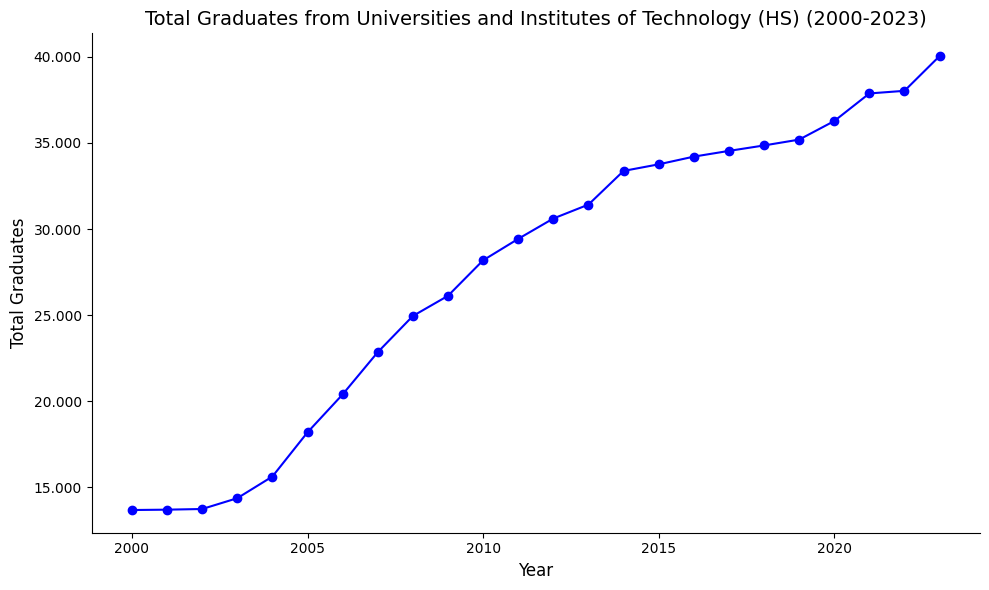

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# SQL query to fetch the data for universities and institutes of technology (HS)
query = """
SELECT
    p.year,
    SUM(g.value) AS total_graduates
FROM
    Graduations g
JOIN
    University_Mapping um ON g.university_mapping_id = um.id
JOIN
    Period p ON g.period_id = p.id
JOIN
    UniversityType ut ON um.university_type_id = ut.id
WHERE
    ut.name = 'HS' AND p.year BETWEEN 2000 AND 2023
GROUP BY
    p.year
ORDER BY
    p.year;
"""

# Execute the query and load data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['total_graduates'], marker='o', linestyle='-', color='b')

# Format y-axis to display with a dot as the thousand separator
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))

# Set chart labels and title
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Graduates", fontsize=12)
plt.title("Total Graduates from Universities and Institutes of Technology (HS) (2000-2023)", fontsize=14)

# Remove the top and right spines (outer lines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()


### 3. Abschlüsse der Fachhochschulen und pädagogischen Hochschulen (2000-2023))

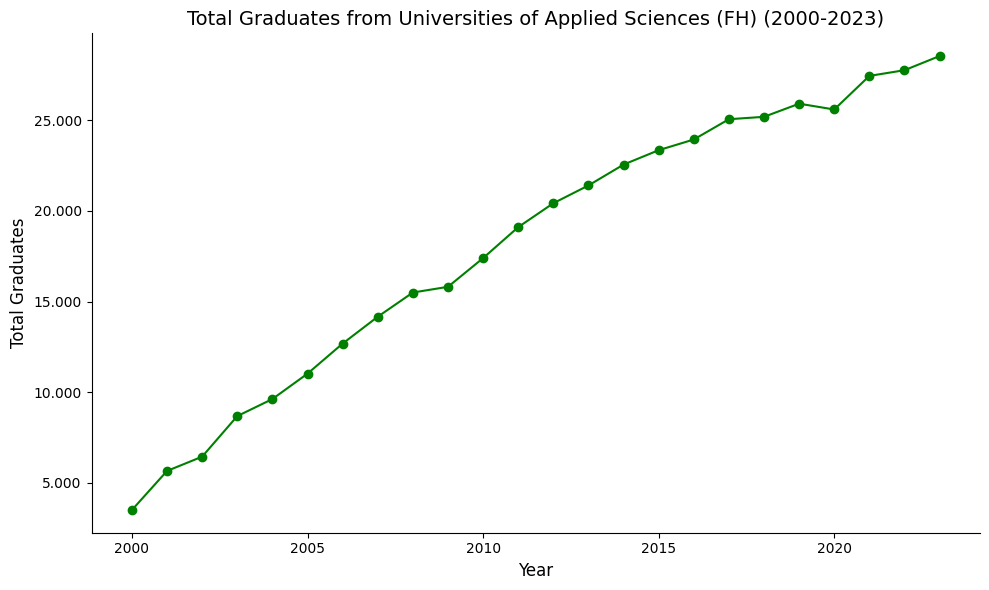

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# SQL query to fetch the data for universities of applied sciences (FH)
query = """
SELECT
    p.year,
    SUM(g.value) AS total_graduates
FROM
    Graduations g
JOIN
    University_Mapping um ON g.university_mapping_id = um.id
JOIN
    Period p ON g.period_id = p.id
JOIN
    UniversityType ut ON um.university_type_id = ut.id
WHERE
    ut.name = 'FH' AND p.year BETWEEN 2000 AND 2023
GROUP BY
    p.year
ORDER BY
    p.year;
"""

# Execute the query and load data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['total_graduates'], marker='o', linestyle='-', color='g')  # Changed color to green

# Format y-axis to display with a dot as the thousand separator
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))

# Set chart labels and title
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Graduates", fontsize=12)
plt.title("Total Graduates from Universities of Applied Sciences (FH) (2000-2023)", fontsize=14)

# Remove the top and right spines (outer lines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()


### 4. Abschlüsse der universitären Hochschulen nach Level (2023)

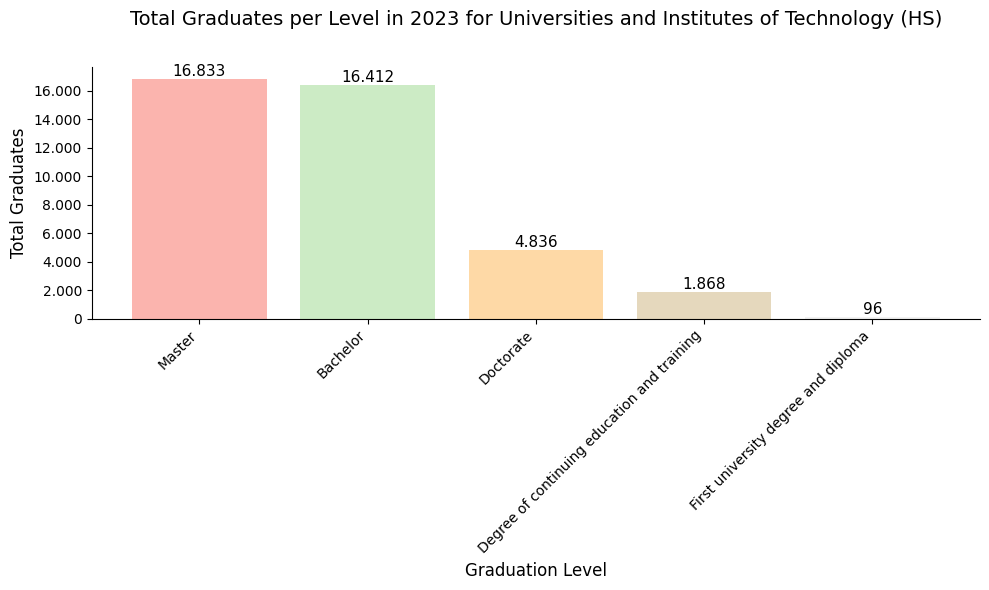

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# SQL query to fetch the data for universities and institutes of technology (HS) in 2023
query = """
SELECT
    l.name AS level_name,
    SUM(g.value) AS total_graduates
FROM
    Graduations g
JOIN
    University_Mapping um ON g.university_mapping_id = um.id
JOIN
    UniversityType ut ON um.university_type_id = ut.id
JOIN
    Level l ON g.level_id = l.id
JOIN
    Period p ON g.period_id = p.id
WHERE
    ut.name = 'HS' AND p.year = 2023
GROUP BY
    l.name
ORDER BY
    total_graduates DESC;
"""

# Execute the query and load data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Define a pastel color palette
colors = plt.cm.Pastel1(np.linspace(0, 1, len(df)))

# Plot the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(df['level_name'], df['total_graduates'], color=colors)

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height):,}'.replace(',', '.'), ha='center', va='bottom', fontsize=11)

# Format y-axis to display with a dot as the thousand separator
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))

# Set chart labels and title
plt.xlabel("Graduation Level", fontsize=12)
plt.ylabel("Total Graduates", fontsize=12)
plt.title("Total Graduates per Level in 2023 for Universities and Institutes of Technology (HS)", fontsize=14, pad=30)

# Remove the top and right spines (outer lines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


### 5. Abschlüsse der Fachhochschulen und pädagogischen Hochschulen nach Level (2023)

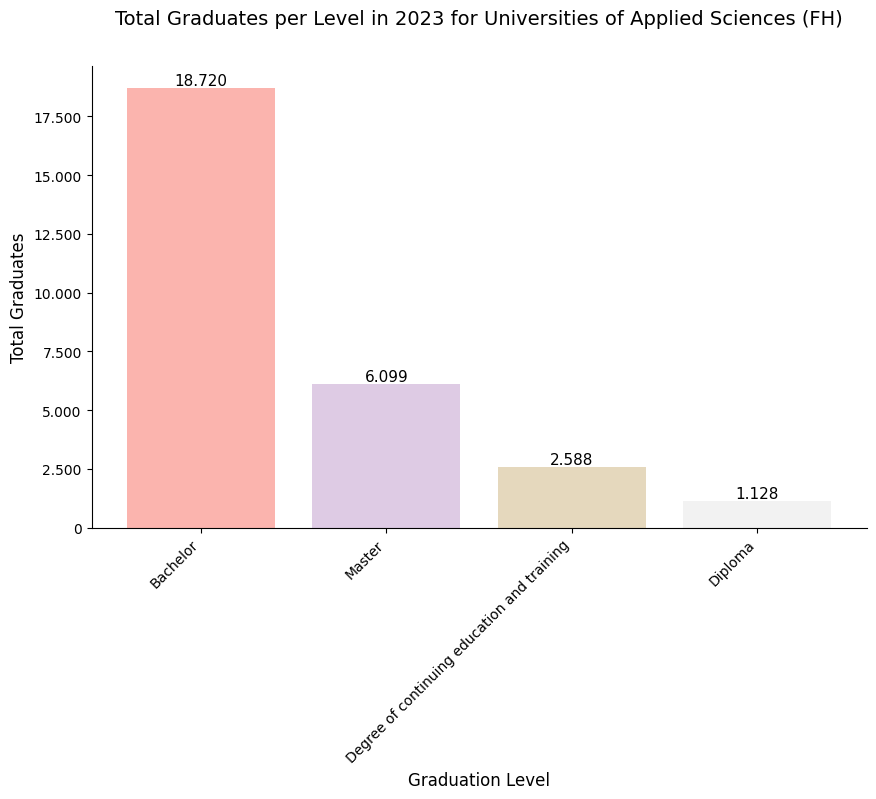

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# SQL query to fetch the data for universities of applied sciences (FH) in 2023
query = """
SELECT
    l.name AS level_name,
    SUM(g.value) AS total_graduates
FROM
    Graduations g
JOIN
    University_Mapping um ON g.university_mapping_id = um.id
JOIN
    UniversityType ut ON um.university_type_id = ut.id
JOIN
    Level l ON g.level_id = l.id
JOIN
    Period p ON g.period_id = p.id
WHERE
    ut.name = 'FH' AND p.year = 2023
GROUP BY
    l.name
ORDER BY
    total_graduates DESC;
"""

# Execute the query and load data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Define a pastel color palette
colors = plt.cm.Pastel1(np.linspace(0, 1, len(df)))

# Plot the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(df['level_name'], df['total_graduates'], color=colors)

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height):,}'.replace(',', '.'), ha='center', va='bottom', fontsize=11)

# Format y-axis to display with a dot as the thousand separator
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))

# Set chart labels and title
plt.xlabel("Graduation Level", fontsize=12)
plt.ylabel("Total Graduates", fontsize=12)
plt.title("Total Graduates per Level in 2023 for Universities of Applied Sciences (FH)", fontsize=14, pad=30)

# Remove the top and right spines (outer lines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


## Feature Engineering

### Erstellen von Interaktionsmerkmalen

In [14]:
# Erstellen von drei Interaktionsmerkmalen: field_university_interaction, field_level_interaction, und field_gender_interaction.
# Diese Merkmale kombinieren jeweils zwei kategoriale Variablen, um spezifische Effekte zu erfassen.

import pandas as pd
import sqlite3
import os

# Define folder paths
output_folder = "output"

# Connect to the SQLite database
db_path = os.path.join(output_folder, "abschluesse.db")
conn = sqlite3.connect(db_path)

# SQL query to fetch the data from the Graduations table
query = """
SELECT
    id,
    period_id,
    university_mapping_id,
    university_type_id,
    field_id,
    level_id,
    gender_id,
    value
FROM
    Graduations;
"""

# Execute the query and load data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Erstellen der Interaktionsmerkmale
df['field_university_interaction'] = df['field_id'].astype(str) + '_' + df['university_type_id'].astype(str)
df['field_level_interaction'] = df['field_id'].astype(str) + '_' + df['level_id'].astype(str)
df['field_gender_interaction'] = df['field_id'].astype(str) + '_' + df['gender_id'].astype(str)

# Hinzufügen neuer Spalten zur Tabelle in der Datenbank
with conn:
    conn.execute("ALTER TABLE Graduations ADD COLUMN field_university_interaction TEXT")
    conn.execute("ALTER TABLE Graduations ADD COLUMN field_level_interaction TEXT")
    conn.execute("ALTER TABLE Graduations ADD COLUMN field_gender_interaction TEXT")

# Aktualisieren der Tabelle mit den neuen Werten
for index, row in df.iterrows():
    conn.execute("""
        UPDATE Graduations
        SET field_university_interaction = ?,
            field_level_interaction = ?,
            field_gender_interaction = ?
        WHERE id = ?
    """, (row['field_university_interaction'], row['field_level_interaction'], row['field_gender_interaction'], row['id']))

# Commit the changes to ensure they are saved
conn.commit()

# Überprüfen, ob die Spalten korrekt hinzugefügt wurden
test_query = "SELECT * FROM Graduations LIMIT 5;"
test_df = pd.read_sql_query(test_query, conn)
print(test_df)

# Close the database connection
conn.close()

   id  period_id  university_mapping_id  university_type_id  field_id  \
0   1         21                      1                   1         1   
1   2         21                      1                   1         1   
2   3         21                      1                   1         2   
3   4         21                      1                   1         2   
4   5         21                      1                   1         2   

   level_id  gender_id  value field_university_interaction  \
0         6          1      9                          1_1   
1         6          2      3                          1_1   
2         2          1     33                          2_1   
3         6          1     23                          2_1   
4         6          2      2                          2_1   

  field_level_interaction field_gender_interaction  
0                     1_6                      1_1  
1                     1_6                      1_2  
2                     2_2    

### Erstellen von aggregierten Merkmalen

In [15]:
# Aggregierte Merkmale werden berechnet, indem die durchschnittliche Anzahl der Absolvent:innen für
# jedes Fachgebiet (field_id) und jeden Universitäts-Typ (university_type_id) ermittelt wird.
# Diese Durchschnittswerte werden dann wieder in den ursprünglichen DataFrame integriert, um die Daten
# für weitere Modellierungen zu erweitern.

conn = sqlite3.connect(db_path)

# SQL-Abfrage, um Daten aus der Graduations-Tabelle abzurufen
query = """
SELECT
    period_id,
    university_mapping_id,
    university_type_id,
    field_id,
    level_id,
    gender_id,
    value
FROM
    Graduations;
"""

# Ausführen der Abfrage und Laden der Daten in einen Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Berechnen der durchschnittlichen Anzahl der Absolventen für jedes field_id
avg_graduates_per_field = df.groupby('field_id')['value'].mean().reset_index()
avg_graduates_per_field.columns = ['field_id', 'avg_graduates_field']

# Berechnen der durchschnittlichen Anzahl der Absolventen für jedes university_type_id
avg_graduates_per_university_type = df.groupby('university_type_id')['value'].mean().reset_index()
avg_graduates_per_university_type.columns = ['university_type_id', 'avg_graduates_university_type']

# Zusammenführen der berechneten Durchschnittswerte mit dem ursprünglichen DataFrame
df = df.merge(avg_graduates_per_field, on='field_id', how='left')
df = df.merge(avg_graduates_per_university_type, on='university_type_id', how='left')

# Anzeigen der ersten Zeilen des DataFrames mit den neuen Merkmalen
print(df.head())

# Schließen der Datenbankverbindung
conn.close()


   period_id  university_mapping_id  university_type_id  field_id  level_id  \
0         21                      1                   1         1         6   
1         21                      1                   1         1         6   
2         21                      1                   1         2         2   
3         21                      1                   1         2         6   
4         21                      1                   1         2         6   

   gender_id  value  avg_graduates_field  avg_graduates_university_type  
0          1      9            28.621508                      67.730769  
1          2      3            28.621508                      67.730769  
2          1     33            71.016336                      67.730769  
3          1     23            71.016336                      67.730769  
4          2      2            71.016336                      67.730769  


### Model 1: Lineare Regression

In [16]:
# --- Modell: Lineare Regression (mit One-Hot Encoding) ---
# Dieses Modell verwendet lineare Regression, um die Absolventenzahlen
# anhand der vorbereiteten Merkmale (inkl. One-Hot-Encoding der kategorialen
# Variablen) vorherzusagen. Es dient als Baseline-Modell.

import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# SQL query to fetch the data for modeling
query = """
SELECT
    period_id,
    university_mapping_id,
    university_type_id,
    field_id,
    level_id,
    gender_id,
    value
FROM
    Graduations
WHERE
    period_id IN (SELECT id FROM Period WHERE year BETWEEN 2000 AND 2022);  -- Using historical data up to 2022 for training
"""

# Execute the query and load the data into a Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Apply One-Hot Encoding to categorical variables
df_encoded = pd.get_dummies(df, columns=['university_mapping_id', 'university_type_id', 'field_id', 'level_id', 'gender_id'])

# Define the features (X) and the target variable (y)
X = df_encoded.drop(columns=['value'])
y = df_encoded['value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

# Close the database connection
conn.close()


Mean Squared Error: 8326.730965132621
Root Mean Squared Error: 91.25092309194807
R^2 Score: 0.3289495907953002


### Model 2. ARIMA

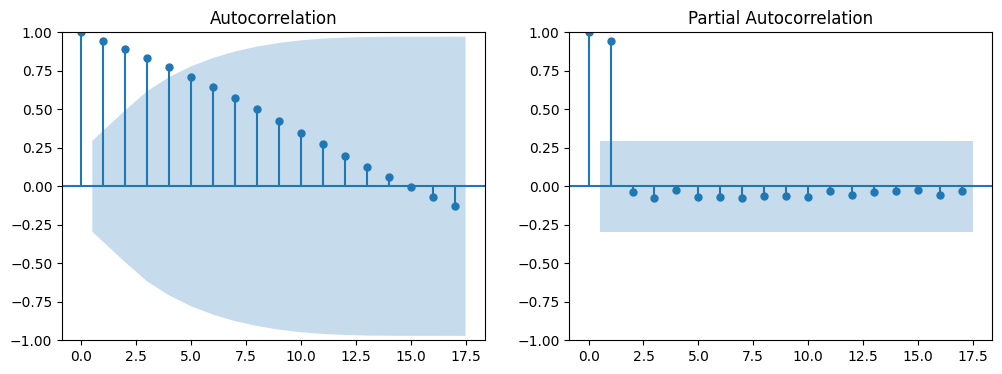

Mean Squared Error: 8348641.337864024
Root Mean Squared Error: 2889.401553585798
R^2 Score: -0.11390491670921143


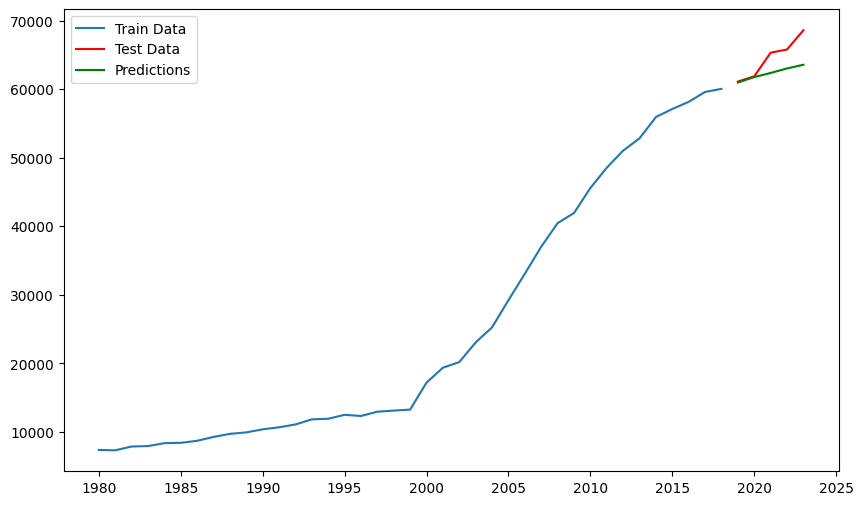

In [17]:
# --- Modell: ARIMA ---
# Implementierung des ARIMA-Modells (Autoregressive Integrated Moving Average)
# zur Prognose der jährlichen Absolventenzahlen. Die Modellordnung (p, d, q)
# wird anhand von ACF- und PACF-Plots bestimmt.

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect(db_path)

# SQL-Abfrage, um die aggregierten Abschlussdaten pro Jahr abzurufen
query = """
SELECT
    p.year,
    SUM(g.value) AS total_graduates
FROM
    Graduations g
JOIN
    Period p ON g.period_id = p.id
GROUP BY
    p.year
ORDER BY
    p.year;
"""

# Ausführen der Abfrage und Laden der Daten in einen Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Konvertieren der 'year'-Spalte in einen Datetime-Index mit jährlicher Frequenz
df['year'] = pd.to_datetime(df['year'].astype(str), format='%Y')
df.set_index('year', inplace=True)
df.index.freq = 'YS'  # Frequenz auf Jahresbeginn setzen

# Plotten von ACF und PACF, um potenzielle ARIMA-Parameter zu identifizieren
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df, ax=axes[0])
plot_pacf(df, ax=axes[1])
plt.show()

# Definieren der Anzahl der Jahre, die für das Testen verwendet werden sollen
test_years = 5  # Diesen Wert können Sie basierend auf Ihren Bedürfnissen anpassen

# Aufteilen der Daten in Trainings- und Testdatensätze
train_data = df[:-test_years]  # Verwenden Sie alle bis auf die letzten 'test_years' für das Training
test_data = df[-test_years:]   # Verwenden Sie die letzten 'test_years' für das Testen

# Anpassen des ARIMA-Modells
# Beispiel-Ordnung (p, d, q), anpassen basierend auf ACF/PACF-Plots
model = ARIMA(train_data, order=(5, 1, 0))
model_fit = model.fit()


# Vorhersagen treffen und in einen Pandas Series konvertieren *VOR* der Auswertung
predictions = model_fit.forecast(steps=test_years)
pred_index = pd.date_range(start=test_data.index[0], periods=test_years, freq='YS')  # Korrekte Indexerstellung
predictions_df = pd.Series(predictions.values, index=pred_index)  # .values extrahieren


# Modell bewerten
mse = mean_squared_error(test_data, predictions_df)
rmse = np.sqrt(mse)
r2 = r2_score(test_data, predictions_df)


print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

# Ergebnisse plotten
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data, label='Test Data', color='red')
plt.plot(predictions_df.index, predictions_df.values, label='Predictions', color='green') # Plotten mit korrektem Index
plt.legend()
plt.show()

# Schließen der Datenbankverbindung
conn.close()

### Model 3. Neural Network

In [18]:
# --- Neuronales Netzwerk (ohne Feature Engineering) ---
# Modellierung nicht-linearer Zusammenhänge

import pandas as pd
import sqlite3
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

conn = sqlite3.connect(db_path)

# SQL query to fetch the data from the Graduations table
query = """
SELECT
    period_id,
    university_mapping_id,
    university_type_id,
    field_id,
    level_id,
    gender_id,
    value
FROM
    Graduations;
"""

# Execute the query and load data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Define features and target variable for the neural network
X_nn = df[['period_id', 'university_mapping_id', 'university_type_id', 'field_id', 'level_id', 'gender_id']]
y_nn = df['value']

# Split the data into training and testing sets for the neural network
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)

# Standardize the features for the neural network
scaler_nn = StandardScaler()
X_train_scaled_nn = scaler_nn.fit_transform(X_train_nn)
X_test_scaled_nn = scaler_nn.transform(X_test_nn)

# Build the neural network model with an Input layer
model_nn = Sequential([
    Input(shape=(X_train_scaled_nn.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the neural network model
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Train the neural network model
model_nn.fit(X_train_scaled_nn, y_train_nn, epochs=100, batch_size=32, validation_split=0.2)

# Make predictions with the neural network model
y_pred_nn = model_nn.predict(X_test_scaled_nn)

# Evaluate the neural network model
mse_nn = mean_squared_error(y_test_nn, y_pred_nn)
print(f"Neural Network Mean Squared Error: {mse_nn}")

# Optionally, save the neural network model
# model_nn.save(os.path.join(output_folder, 'neural_network_model.h5'))

# Close the database connection
conn.close()


Epoch 1/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14028.2812 - val_loss: 12560.8516
Epoch 2/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 10927.9561 - val_loss: 12313.2686
Epoch 3/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 10768.7979 - val_loss: 12147.3154
Epoch 4/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 10640.2568 - val_loss: 11984.4297
Epoch 5/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 10508.6309 - val_loss: 11819.3457
Epoch 6/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 10375.0068 - val_loss: 11651.6885
Epoch 7/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 10243.1162 - val_loss: 11484.8828
Epoch 8/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 10113.7695 - val_loss: 11337.7314
Epoch 9/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 9995.7207 - val_loss: 11201.8857
Epoch 10/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 9888.5186 - val_loss: 11089.4463
Epoch 11/100
396/396 ━━━━━━━━━━━━

In [19]:
# --- Neuronales Netzwerk (mit Feature Engineering) ---
# Prognose der Absolventenzahlen mit erweitertem Feature-Set.
# Beinhaltet Interaktionsmerkmale.

import pandas as pd
import sqlite3
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect(db_path)

# SQL-Abfrage, um die Daten aus der Graduations-Tabelle abzurufen
query = """
SELECT
    period_id,
    university_mapping_id,
    university_type_id,
    field_id,
    level_id,
    gender_id,
    value,
    field_university_interaction,
    field_level_interaction,
    field_gender_interaction
FROM
    Graduations;
"""

# Ausführen der Abfrage und Laden der Daten in einen Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Definieren der Features und der Zielvariablen für das neuronale Netzwerk
X_nn = df[['period_id', 'university_mapping_id', 'university_type_id', 'field_id', 'level_id', 'gender_id',
           'field_university_interaction', 'field_level_interaction', 'field_gender_interaction']]
y_nn = df['value']

# Aufteilen der Daten in Trainings- und Testdatensätze für das neuronale Netzwerk
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)

# Standardisieren der Features für das neuronale Netzwerk
scaler_nn = StandardScaler()
X_train_scaled_nn = scaler_nn.fit_transform(X_train_nn)
X_test_scaled_nn = scaler_nn.transform(X_test_nn)

# Aufbau des neuronalen Netzwerkmodells mit einer Input-Schicht
model_nn = Sequential([
    Input(shape=(X_train_scaled_nn.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output-Schicht für Regression
])

# Kompilieren des neuronalen Netzwerkmodells
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Trainieren des neuronalen Netzwerkmodells
model_nn.fit(X_train_scaled_nn, y_train_nn, epochs=100, batch_size=32, validation_split=0.2)

# Vorhersagen mit dem neuronalen Netzwerkmodell treffen
y_pred_nn = model_nn.predict(X_test_scaled_nn)

# Bewerten des neuronalen Netzwerkmodellsa
mse_nn = mean_squared_error(y_test_nn, y_pred_nn)
print(f"Neural Network Mean Squared Error: {mse_nn}")

# Optional: Speichern des neuronalen Netzwerkmodells
# model_nn.save(os.path.join(output_folder, 'neural_network_model.h5'))

conn.close()

Epoch 1/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - loss: 14003.3477 - val_loss: 12713.7646
Epoch 2/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 10987.2617 - val_loss: 12306.4062
Epoch 3/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 10756.2012 - val_loss: 12093.9619
Epoch 4/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 10599.8076 - val_loss: 11899.4316
Epoch 5/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 10457.6172 - val_loss: 11705.7744
Epoch 6/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 10319.2168 - val_loss: 11516.9160
Epoch 7/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 10183.2334 - val_loss: 11343.8174
Epoch 8/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 10056.7285 - val_loss: 11195.1777
Epoch 9/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 9938.8496 - val_loss: 11044.7422
Epoch 10/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 9818.1865 - val_loss: 10911.5059
Epoch 11/100
396/396 ━━━━━━━━━━

In [20]:
# --- Neuronales Netzwerk (mit Feature Engineering) ---
# Neuronales Netzwerk zur Erfassung potenziell nicht-linearer Beziehungen.
# Eingabe: Numerische und one-hot-encodierte kategoriale Merkmale,
#          inkl. Interaktionsmerkmale.
# Architektur: Zwei Dense-Schichten (ReLU), lineare Ausgabe.
# Training: Adam, MSE-Loss, 100 Epochen, Batch-Size 32, 20% Validation.
# Standardisierung der Eingabedaten.

import pandas as pd
import sqlite3
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# SQL query to fetch the data from the Graduations table
query = """
SELECT
    period_id,
    university_mapping_id,
    university_type_id,
    field_id,
    level_id,
    gender_id,
    value,
    field_university_interaction,
    field_level_interaction,
    field_gender_interaction
FROM
    Graduations;
"""

# Execute the query and load the data into a Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Apply One-Hot Encoding to categorical variables
df_encoded = pd.get_dummies(df, columns=['university_mapping_id', 'university_type_id', 'field_id', 'level_id', 'gender_id'])

# Define the features and the target variable for the neural network
X_nn = df_encoded.drop(columns=['value'])
y_nn = df_encoded['value']

# Split the data into training and testing sets for the neural network
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)

# Standardize the features for the neural network
scaler_nn = StandardScaler()
X_train_scaled_nn = scaler_nn.fit_transform(X_train_nn)
X_test_scaled_nn = scaler_nn.transform(X_test_nn)

# Build the neural network model with an Input layer
model_nn = Sequential([
    Input(shape=(X_train_scaled_nn.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the neural network model
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Train the neural network model
model_nn.fit(X_train_scaled_nn, y_train_nn, epochs=100, batch_size=32, validation_split=0.2)

# Make predictions with the neural network model
y_pred_nn = model_nn.predict(X_test_scaled_nn)

# Evaluate the neural network model
mse_nn = mean_squared_error(y_test_nn, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)  # Calculate RMSE
r2_nn = r2_score(y_test_nn, y_pred_nn) # Calculate R-squared


print(f"Neural Network Mean Squared Error: {mse_nn}")
print(f"Neural Network Root Mean Squared Error: {rmse_nn}")  # Print RMSE
print(f"Neural Network R^2 Score: {r2_nn}")  # Print R-squared

# Optional: Save the neural network model
# model_nn.save(os.path.join(output_folder, 'neural_network_model.h5'))

# Close the database connection
conn.close()


Epoch 1/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - loss: 12684.1416 - val_loss: 8683.8574
Epoch 2/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 7665.7705 - val_loss: 7504.2427
Epoch 3/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 6770.2402 - val_loss: 6653.3813
Epoch 4/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 5997.3467 - val_loss: 5910.2061
Epoch 5/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 5298.1777 - val_loss: 5273.2651
Epoch 6/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 4712.0596 - val_loss: 4776.4087
Epoch 7/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 4236.2617 - val_loss: 4368.1982
Epoch 8/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 3840.9600 - val_loss: 4033.4893
Epoch 9/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 3513.9104 - val_loss: 3783.4102
Epoch 10/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 3244.0618 - val_loss: 3550.4172
Epoch 11/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 556

### Model 4. Decision Tree Regressor

Decision Tree Mean Squared Error: 1310.8891700404859


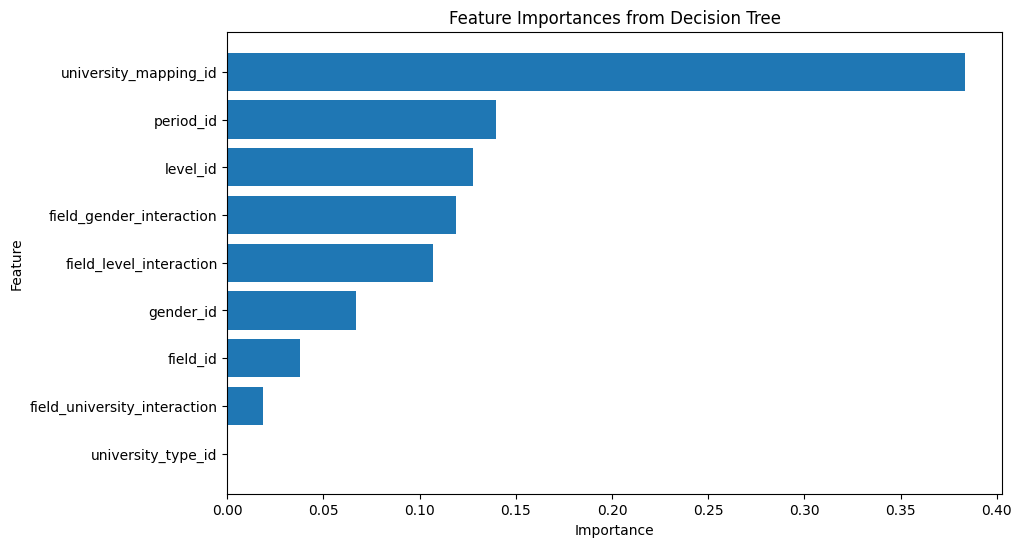

In [21]:
# --- Decision Tree Regressor (Feature Importance) ---
# Decision Tree zur Analyse der Merkmalbedeutungen (Feature Importance).
# Ursprüngliche und Interaktionsmerkmale werden verwendet.
# Train/Test-Split: 80/20, random_state=42.
# Ausgabe: MSE und Feature Importance Plot.

import pandas as pd
import sqlite3
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt


# Define folder paths
output_folder = "output"

# Connect to the SQLite database
db_path = os.path.join(output_folder, "abschluesse.db")
conn = sqlite3.connect(db_path)

# SQL query to fetch the data from the Graduations table
query = """
SELECT
    period_id,
    university_mapping_id,
    university_type_id,
    field_id,
    level_id,
    gender_id,
    value,
    field_university_interaction,
    field_level_interaction,
    field_gender_interaction
FROM
    Graduations;
"""

# Execute the query and load data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Define features and target variable for Decision Tree
X_dt = df[['period_id', 'university_mapping_id', 'university_type_id', 'field_id', 'level_id', 'gender_id',
           'field_university_interaction', 'field_level_interaction', 'field_gender_interaction']]
y_dt = df['value']

# Split the data into training and testing sets for Decision Tree
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.2, random_state=42)

# Train the Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_dt, y_train_dt)

# Make predictions with the Decision Tree model
y_pred_dt = dt_model.predict(X_test_dt)

# Evaluate the Decision Tree model
mse_dt = mean_squared_error(y_test_dt, y_pred_dt)
print(f"Decision Tree Mean Squared Error: {mse_dt}")

# Get feature importances
importances = dt_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': X_dt.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree')
plt.gca().invert_yaxis()
plt.show()

# Close the database connection
conn.close()

In [22]:
# --- Decision Tree Regressor (Hyperparameter Tuning) ---
# Der Code verwendet GridSearchCV, um systematisch verschiedene Kombinationen von Hyperparametern
# für einen Entscheidungsbaum zu testen, die Leistung jeder Kombination mittels Kreuzvalidierung
# zu bewerten und das Modell mit den besten Hyperparametern auszuwählen.
# Das Ziel ist, ein Modell zu finden, das gut generalisiert und somit gute Vorhersagen auf neuen, unbekannten Daten liefert.

import pandas as pd
import sqlite3
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

conn = sqlite3.connect(db_path)

# SQL query to fetch the data from the Graduations table
query = """
SELECT
    period_id,
    university_mapping_id,
    university_type_id,
    field_id,
    level_id,
    gender_id,
    value,
    field_university_interaction,
    field_level_interaction,
    field_gender_interaction
FROM
    Graduations;
"""

# Execute the query and load data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Define features and target variable for Decision Tree
X_dt = df[['period_id', 'university_mapping_id', 'university_type_id', 'field_id', 'level_id', 'gender_id',
           'field_university_interaction', 'field_level_interaction', 'field_gender_interaction']]
y_dt = df['value']

# Split the data into training and testing sets for Decision Tree
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}

# Set up the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Perform the grid search
grid_search.fit(X_train_dt, y_train_dt)

# Get the best model from grid search
best_dt_model = grid_search.best_estimator_

# Make predictions with the best Decision Tree model
y_pred_dt = best_dt_model.predict(X_test_dt)

# Evaluate the best Decision Tree model
mse_dt = mean_squared_error(y_test_dt, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)  # Calculate RMSE
r2_dt = r2_score(y_test_dt, y_pred_dt)  # Calculate R-squared

print(f"Decision Tree Mean Squared Error: {mse_dt}")
print(f"Decision Tree Root Mean Squared Error: {rmse_dt}")  # Print RMSE
print(f"Decision Tree R^2 Score: {r2_dt}")  # Print R-squared
print(f"Best Parameters: {grid_search.best_params_}")

# Close the database connection
conn.close()


Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_

### Model 5: Gradient Boosting Regressor w. Hyperparameter Tuning

FH Aggregated Training Data Shape: (6448, 9)
   period_id  university_mapping_id  field_id  level_id  gender_id  \
0         21                      1         1         6          1   
1         21                      1         1         6          2   
2         21                      1         2         2          1   
3         21                      1         2         6          1   
4         21                      1         2         6          2   

  field_university_interaction field_level_interaction  \
0                          1_1                     1_6   
1                          1_1                     1_6   
2                          2_1                     2_2   
3                          2_1                     2_6   
4                          2_1                     2_6   

  field_gender_interaction  total_value  
0                      1_1            9  
1                      1_2            3  
2                      2_1           33  
3                

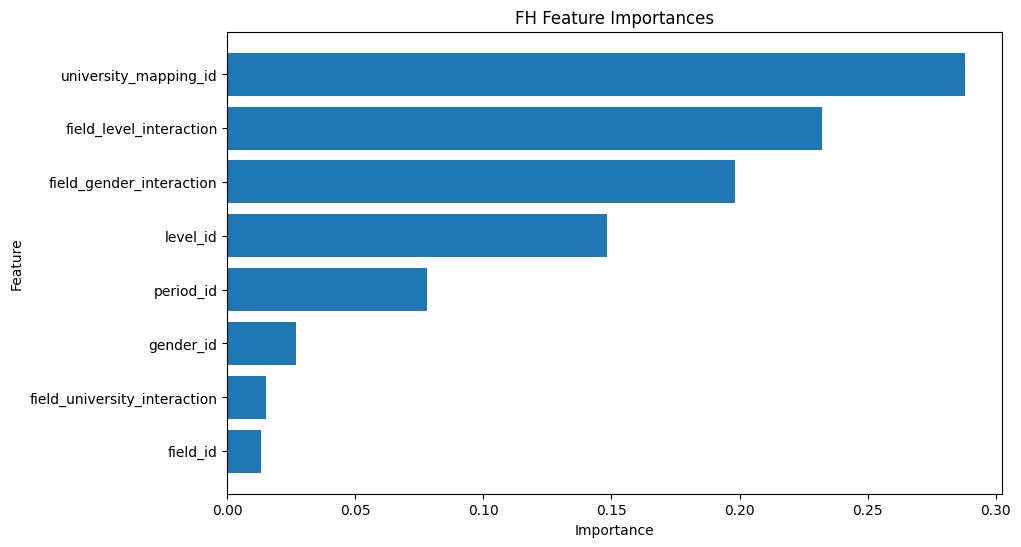

In [23]:
# --- GBM (FH-Daten, initiales Training, *ohne* Kreuzvalidierung) ---
# Trainiert ein GBM *nur* auf den FH-Daten. Dient als erster Versuch
# vor der Implementierung der Kreuzvalidierung.

import pandas as pd
import sqlite3
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import joblib

# Define folder paths
output_folder = "output"

# Connect to the database
db_path = os.path.join(output_folder, "abschluesse.db")
conn = sqlite3.connect(db_path)

# Query aggregated training data for FH using fh_id from University_Mapping
query_fh_train = """
SELECT 
    period_id,
    um.fh_id AS university_mapping_id,
    field_id,
    level_id,
    gender_id,
    field_university_interaction,
    field_level_interaction,
    field_gender_interaction,
    SUM(value) AS total_value
FROM Graduations g
JOIN University_Mapping um ON g.university_mapping_id = um.id
WHERE g.university_type_id = 1
GROUP BY period_id, university_mapping_id, field_id, level_id, gender_id,
         field_university_interaction, field_level_interaction, field_gender_interaction;
"""
train_df = pd.read_sql_query(query_fh_train, conn)
conn.close()

print("FH Aggregated Training Data Shape:", train_df.shape)
print(train_df.head())

# Filter for period_ids corresponding to 2000-2023 (assumed as 21–44)
train_df = train_df[(train_df['period_id'] >= 21) & (train_df['period_id'] <= 44)]

# Define features and target
features = ['period_id', 'university_mapping_id', 'field_id', 'level_id', 'gender_id',
            'field_university_interaction', 'field_level_interaction', 'field_gender_interaction']
X = train_df[features]
y = train_df['total_value']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up and run GridSearchCV
gbm = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("FH Aggregated Training MSE:", mse)
print("Best Parameters:", grid_search.best_params_)

# Save the trained model
model_filename = os.path.join(output_folder, 'best_gbm_model_fh_agg.pkl')
joblib.dump(best_model, model_filename)
print("Model saved to", model_filename)

# Plot feature importances
importances = best_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('FH Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [24]:
# --- FH-Vorhersage für 2024 ---
# Dieses Code-Segment lädt das zuvor trainierte und gespeicherte
# Gradient Boosting Regressor Modell für Fachhochschulen (FH).
# Es erstellt dann einen Datensatz für das Jahr 2024 mit allen
# relevanten Feature-Kombinationen und verwendet das Modell, um die
# Absolventenzahlen für jede Kombination vorherzusagen. Die vorhergesagten
# Werte werden anschließend aufsummiert, um die prognostizierte
# Gesamtzahl der FH-Absolventen für 2024 zu erhalten.

import pandas as pd
import sqlite3
import os
import joblib

# Define folder paths
output_folder = "output"

# Load the trained FH model (aggregated version)
model_filename = os.path.join(output_folder, 'best_gbm_model_fh_agg.pkl')
fh_model = joblib.load(model_filename)

# Connect to the database
db_path = os.path.join(output_folder, "abschluesse.db")
conn = sqlite3.connect(db_path)

# Query distinct aggregated feature combinations for FH from historical data
query_fh_predict = """
SELECT DISTINCT 
    um.fh_id AS university_mapping_id,
    field_id,
    level_id,
    gender_id,
    field_university_interaction,
    field_level_interaction,
    field_gender_interaction
FROM Graduations g
JOIN University_Mapping um ON g.university_mapping_id = um.id
WHERE g.university_type_id = 1;
"""
predict_df = pd.read_sql_query(query_fh_predict, conn)
conn.close()

# Set period_id for 2025 (e.g. period_id 46)
period_2024 = 45
predict_df['period_id'] = period_2024

# Order columns as expected by the model
predict_columns = ['period_id', 'university_mapping_id', 'field_id', 'level_id', 'gender_id',
                   'field_university_interaction', 'field_level_interaction', 'field_gender_interaction']
predict_df = predict_df[predict_columns]

print("FH Aggregated Prediction DataFrame Shape:", predict_df.shape)

# Make predictions using the aggregated model
predict_df['predicted_total'] = fh_model.predict(predict_df)

# Sum predictions to get the total predicted graduates for FH in 2025
total_predicted = predict_df['predicted_total'].sum()
print("Total Predicted Graduates for FH in 2024 (Aggregated):")
print(total_predicted)


FH Aggregated Prediction DataFrame Shape: (624, 8)
Total Predicted Graduates for FH in 2024 (Aggregated):
39188.196924197706


HS Training Data Shape: (13310, 9)
   period_id  university_mapping_id  field_id  level_id  gender_id  value  \
0          1                      1        15         1          1     32   
1          1                      1        15         1          2     22   
2          1                      1        15         5          0      1   
3          1                      1        15         5          1     11   
4          1                      1        15         5          2      5   

  field_university_interaction field_level_interaction  \
0                         15_2                    15_1   
1                         15_2                    15_1   
2                         15_2                    15_5   
3                         15_2                    15_5   
4                         15_2                    15_5   

  field_gender_interaction  
0                     15_1  
1                     15_2  
2                     15_0  
3                     15_1  
4       

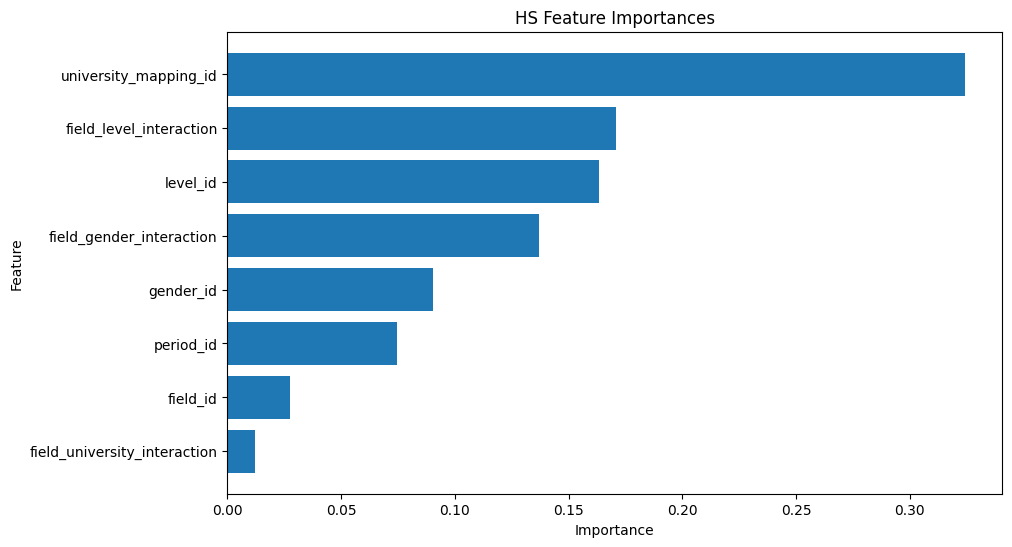

In [25]:
# --- GBM (HS-Daten, initiales Training) ---
# Trainiert ein GBM *nur* auf den HS-Daten.

import pandas as pd
import sqlite3
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Define folder paths
output_folder = "output"

# Connect to the database
db_path = os.path.join(output_folder, "abschluesse.db")
conn = sqlite3.connect(db_path)

# Query training data for HS (use hs_id from University_Mapping)
query_hs_train = """
SELECT 
    g.period_id,
    um.hs_id AS university_mapping_id,
    g.field_id,
    g.level_id,
    g.gender_id,
    g.value,
    g.field_university_interaction,
    g.field_level_interaction,
    g.field_gender_interaction
FROM Graduations g
JOIN University_Mapping um ON g.university_mapping_id = um.id
WHERE g.university_type_id = 2;
"""
train_df = pd.read_sql_query(query_hs_train, conn)
conn.close()

print("HS Training Data Shape:", train_df.shape)
print(train_df.head())

# Filter for available years (e.g. 2000–2023)
train_df = train_df[(train_df['period_id'] >= 21) & (train_df['period_id'] <= 44)]

# Define features and target
X = train_df[['period_id', 'university_mapping_id', 'field_id', 'level_id', 'gender_id',
              'field_university_interaction', 'field_level_interaction', 'field_gender_interaction']]
y = train_df['value']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up and run GridSearchCV for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gbm = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# --- Calculate Metrics ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(y_test, y_pred)  # Calculate R-squared

print("HS Training MSE:", mse)
print("HS Training RMSE:", rmse)  # Print RMSE
print("HS Training R^2 Score:", r2)  # Print R-squared
print("Best Parameters:", grid_search.best_params_)

# Save the trained model (no scaling)
model_filename = os.path.join(output_folder, 'best_gbm_model_hs_noscaler.pkl')
joblib.dump(best_model, model_filename)
print("Model saved to", model_filename)

# Plot feature importances
importances = best_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('HS Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [26]:
# --- HS-Vorhersage für 2024 ---
# Dieses Code-Segment lädt das zuvor trainierte und gespeicherte
# Gradient Boosting Regressor Modell für Universitäten (HS).
# Es erstellt dann einen Datensatz für das Jahr 2024 mit allen
# relevanten Feature-Kombinationen und verwendet das Modell, um die
# Absolventenzahlen für jede Kombination vorherzusagen. Die vorhergesagten
# Werte werden anschließend aufsummiert, um die prognostizierte
# Gesamtzahl der HS-Absolventen für 2024 zu erhalten.
import pandas as pd
import sqlite3
import os
import joblib

# Define folder paths
output_folder = "output"

# Load the trained HS model (no scaler used)
model_filename = os.path.join(output_folder, 'best_gbm_model_hs_noscaler.pkl')
best_model = joblib.load(model_filename)

# Connect to the database
db_path = os.path.join(output_folder, "abschluesse.db")
conn = sqlite3.connect(db_path)

# Revised query: include gender_id so each row already corresponds to a specific gender
query_predict = """
SELECT DISTINCT um.hs_id AS university_mapping_id,
       g.field_id,
       g.level_id,
       g.gender_id,
       g.field_university_interaction,
       g.field_level_interaction,
       g.field_gender_interaction
FROM Graduations g
JOIN University_Mapping um ON g.university_mapping_id = um.id
WHERE g.university_type_id = 2;
"""
predict_df = pd.read_sql_query(query_predict, conn)
conn.close()

# Set period_id for 2025 (e.g., period_id 46)
year_2025 = 46
predict_df['period_id'] = year_2025

# Order columns as expected by the model
columns = ['period_id', 'university_mapping_id', 'field_id', 'level_id', 'gender_id',
           'field_university_interaction', 'field_level_interaction', 'field_gender_interaction']
predict_df = predict_df[columns]

print("HS Prediction DataFrame Shape:", predict_df.shape)

# Make predictions
predict_df['predicted_graduates'] = best_model.predict(predict_df)

# Sum predictions to get the total predicted graduates
total_graduates = predict_df['predicted_graduates'].sum()
print("Total Predicted Graduates for HS in 2025:")
print(total_graduates)


HS Prediction DataFrame Shape: (629, 8)
Total Predicted Graduates for HS in 2025:
39304.62476598726


In [27]:
# --- GBM (FH-Daten, Kreuzvalidierung) ---
# Kreuzvalidierung des GBM-Modells zur robusten Evaluierung der
# Modellgüte auf den FH-Daten.

import pandas as pd
import sqlite3
import os
import joblib
import numpy as np
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define folder paths and DB path
output_folder = "output"
db_path = os.path.join(output_folder, "abschluesse.db")

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Load the saved aggregated FH model
model_filename = os.path.join(output_folder, 'best_gbm_model_fh_agg.pkl')
fh_model = joblib.load(model_filename)

# Query aggregated training data for FH using proper fh_id and summing values
query = """
SELECT 
    period_id,
    um.fh_id AS university_mapping_id,
    field_id,
    level_id,
    gender_id,
    field_university_interaction,
    field_level_interaction,
    field_gender_interaction,
    SUM(value) AS total_value
FROM Graduations g
JOIN University_Mapping um ON g.university_mapping_id = um.id
WHERE g.university_type_id = 1
GROUP BY period_id, university_mapping_id, field_id, level_id, gender_id,
         field_university_interaction, field_level_interaction, field_gender_interaction
"""
agg_df = pd.read_sql_query(query, conn)
conn.close()

# Prepare features and target
features = ['period_id', 'university_mapping_id', 'field_id', 'level_id', 'gender_id',
            'field_university_interaction', 'field_level_interaction', 'field_gender_interaction']
X = agg_df[features]
y = agg_df['total_value']

# Set up cross-validation
np.random.seed(42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation predictions
y_pred = cross_val_predict(fh_model, X, y, cv=kf)

# Calculate performance metrics
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mse)

# Output performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 938.4469994711192
Mean Absolute Error (MAE): 15.627174866278144
R-squared (R²): 0.9477638276161258
Root Mean Squared Error (RMSE): 30.63408231808355


### Quercheck GBM mit nur einem Feature

In [ ]:
# Aufgrund der kontinuierlich schlechten/unklaren Perfomancewerte des GBM wird hier ein Check mit nur einem feature 
# durchgeführt, um zu sehen, ob das Modell überhaupt in der Lage ist, eine Vorhersage zu treffen.

import pandas as pd
import sqlite3
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import joblib

# Define folder paths and database path
fh_output_folder = "output"
fh_db_path = os.path.join(fh_output_folder, "abschluesse.db")

# Connect to SQLite database
fh_conn = sqlite3.connect(fh_db_path)

# Query FH data: only period_id and value for university_type_id=1 (2000–2023)
fh_query = """
SELECT period_id, value
FROM Graduations
WHERE university_type_id = 1
  AND period_id BETWEEN 21 AND 44
"""
fh_train_df = pd.read_sql_query(fh_query, fh_conn)
fh_conn.close()

# Define feature (X) and target (y)
fh_X = fh_train_df[['period_id']]
fh_y = fh_train_df['value']

# Split the data
fh_X_train, fh_X_test, fh_y_train, fh_y_test = train_test_split(fh_X, fh_y, test_size=0.2, random_state=42)

# Set up GridSearchCV with a simple parameter grid
fh_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [2, 3]
}

fh_gbm = GradientBoostingRegressor(random_state=42)
fh_grid_search = GridSearchCV(fh_gbm, fh_param_grid, cv=3, n_jobs=-1, verbose=1)
fh_grid_search.fit(fh_X_train, fh_y_train)

fh_best_model = fh_grid_search.best_estimator_
fh_y_pred = fh_best_model.predict(fh_X_test)
fh_mse = mean_squared_error(fh_y_test, fh_y_pred)
print("FH Single-Feature MSE:", fh_mse)
print("FH Best Params:", fh_grid_search.best_params_)

# Save the trained model
fh_model_filename = os.path.join(fh_output_folder, 'fh_single_feature_model.pkl')
joblib.dump(fh_best_model, fh_model_filename)
print("FH model saved to", fh_model_filename)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
FH Single-Feature MSE: 17898.876076229903
FH Best Params: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}
FH model saved to output/fh_single_feature_model.pkl


In [29]:
import pandas as pd
import os
import joblib

# Define folder paths
fh_output_folder = "output"
fh_model_filename = os.path.join(fh_output_folder, 'fh_single_feature_model.pkl')

# Load the trained FH model
fh_best_model = joblib.load(fh_model_filename)

# Create a DataFrame for prediction: set period_id (for example, 46 for 2025)
fh_pred_input_df = pd.DataFrame({'period_id': [46]})

# Make prediction
fh_predicted_value = fh_best_model.predict(fh_pred_input_df)
print("Predicted FH value for period_id=46:", fh_predicted_value[0])


Predicted FH value for period_id=46: 74.25716053351034


## Model 6: LSTM — Long short-term memory 

Train RMSE: 995.74
Test RMSE: 586.94
Train R^2: 0.95
Test R^2: 0.67


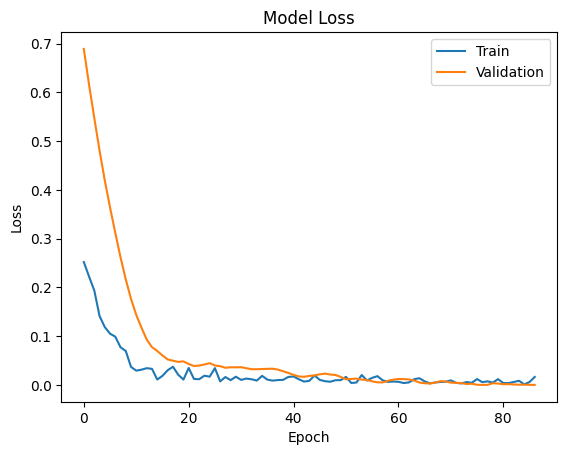

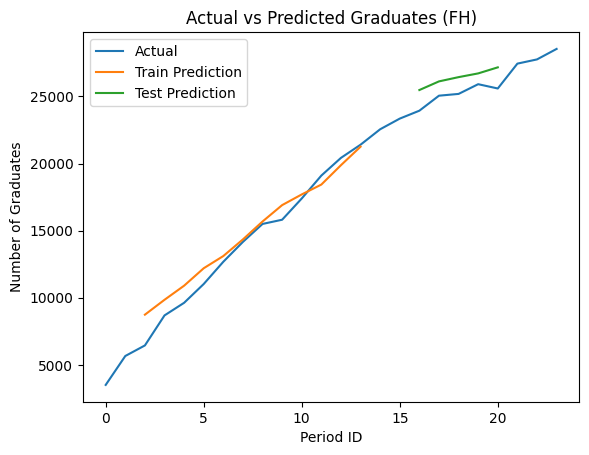

Predicted total graduates for FH in 2024: 28668.85
Number of periods in original grouped data: 24
Number of sequences: 21
Number of training sequences: 12
Number of validation sequences: 4
Number of test sequences: 5


In [30]:
# --- LSTM-Modell ---
# Implementiert ein LSTM-Netzwerk für die Zeitreihenprognose.
# Verwendet eine LSTM-Schicht, Dropout und eine Dense-Ausgabeschicht.

import pandas as pd
import sqlite3
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

# Define folder paths
output_folder = "output"
db_path = os.path.join(output_folder, "abschluesse.db")

# --- Data Loading ---
conn = sqlite3.connect(db_path)
query = "SELECT period_id, university_type_id, value FROM Graduations;"
df = pd.read_sql_query(query, conn)
conn.close()

df_fh = df[df['university_type_id'] == 1]
df_grouped = df_fh.groupby('period_id')['value'].sum().reset_index()

# --- Data Preparation ---
scaler = MinMaxScaler()
df_grouped['value_scaled'] = scaler.fit_transform(df_grouped['value'].values.reshape(-1, 1))

def create_sequences(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 2  # Behalte look_back = 2 vorerst bei
X, Y = create_sequences(df_grouped['value_scaled'].values.reshape(-1, 1), look_back)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:len(X)]
y_train, y_test = Y[:train_size], Y[train_size:len(X)]
X_train, X_val = X_train[:int(0.8*len(X_train))], X_train[int(0.8*len(X_train)):]
y_train, y_val = y_train[:int(0.8*len(y_train))], y_train[int(0.8*len(y_train)):]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# --- Model Building and Training ---
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=10))  # Nur eine LSTM-Schicht, 10 units
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])

# --- Prediction and Evaluation ---
train_predict = model.predict(X_train, verbose=0)
test_predict = model.predict(X_test, verbose=0)

train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


# --- Calculate Metrics ---
train_mse = mean_squared_error(y_train_inv, train_predict)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inv, train_predict)

test_mse = mean_squared_error(y_test_inv, test_predict)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_inv, test_predict)


print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train R^2: {train_r2:.2f}')  # Print train R-squared
print(f'Test R^2: {test_r2:.2f}')   # Print test R-squared

# --- Plotting ---
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

trainPredictPlot = np.empty_like(df_grouped['value_scaled'].values.reshape(-1, 1))
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back] = train_predict

testPredictPlot = np.empty_like(df_grouped['value_scaled'].values.reshape(-1, 1))
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2):len(train_predict) + (look_back * 2) + len(test_predict)] = test_predict

plt.plot(scaler.inverse_transform(df_grouped['value_scaled'].values.reshape(-1, 1)), label='Actual')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.title('Actual vs Predicted Graduates (FH)')
plt.xlabel('Period ID')
plt.ylabel('Number of Graduates')
plt.legend()
plt.show()

# --- Prediction for 2024 ---
last_years = df_grouped['value_scaled'].values[-look_back:].reshape(1, look_back, 1)
pred_2024_scaled = model.predict(last_years, verbose=0)
pred_2024 = scaler.inverse_transform(pred_2024_scaled)[0][0]
print(f"Predicted total graduates for FH in 2024: {pred_2024:.2f}")

# --- Print Data Split Information ---
print(f"Number of periods in original grouped data: {len(df_grouped)}")
print(f"Number of sequences: {len(X)}")
print(f"Number of training sequences: {len(X_train)}")
print(f"Number of validation sequences: {len(X_val)}")
print(f"Number of test sequences: {len(X_test)}")

## Model 7: Prophet - Basemodell ohne Feature Engineering

Importing plotly failed. Interactive plots will not work.
13:33:00 - cmdstanpy - INFO - Chain [1] start processing
13:33:00 - cmdstanpy - INFO - Chain [1] done processing


Test RMSE: 805.88


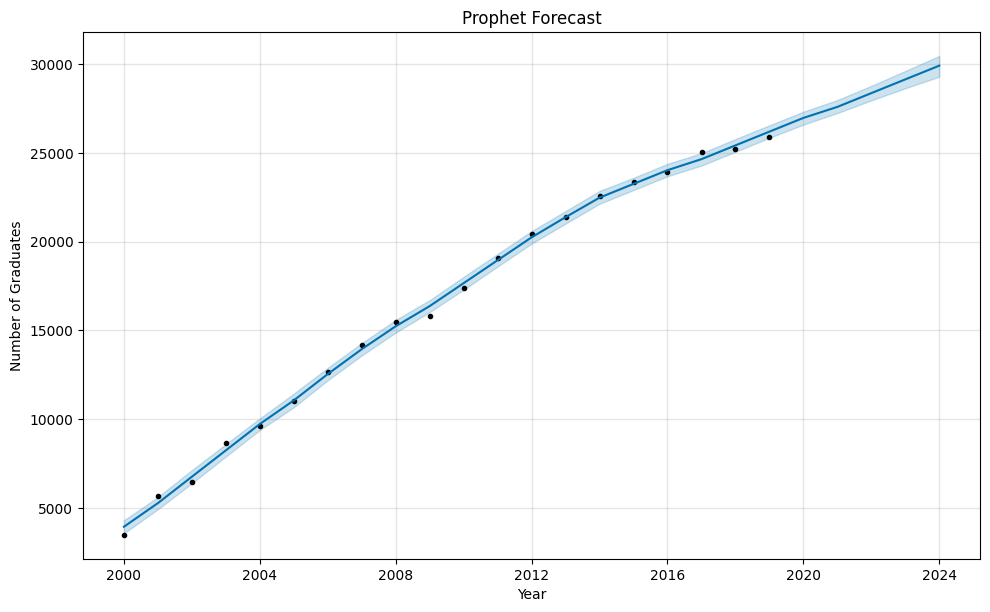

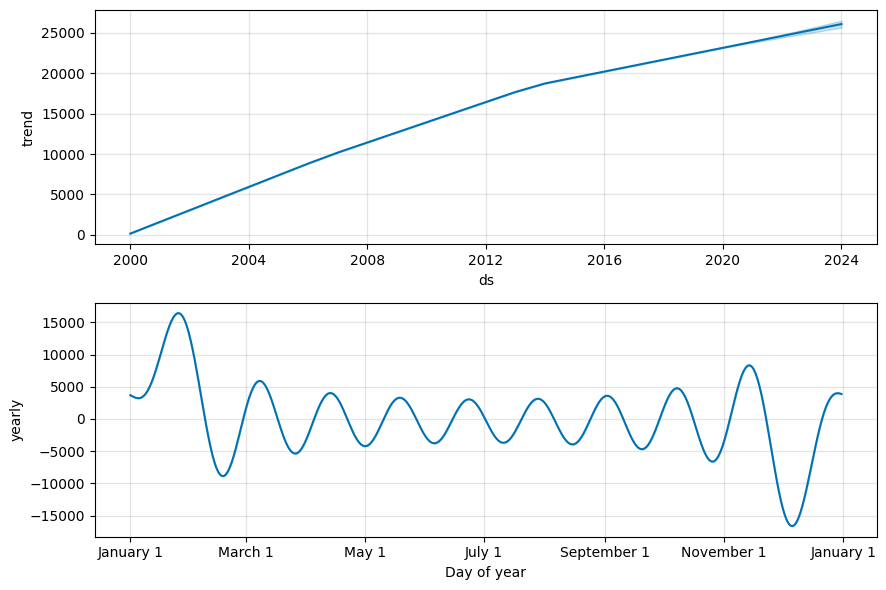

Predicted total graduates for FH in 2024: 29896.06
Number of periods in original grouped data: 24
Number of training periods: 20
Number of test periods: 4


In [31]:
# --- Prophet-Modell (Basis, FH) ---
# Dieses Code-Segment implementiert das Prophet-Modell zur Prognose der
# jährlichen Absolventenzahlen an Fachhochschulen (FH).
#
# - Daten werden aus der DB geladen, nach FH gefiltert und jährlich aggregiert.
# - Zeitraum: 2000-2023
# - Konvertierung der Jahreszahlen in datetime-Objekte (ds, y Spalten).
# - Train/Test-Split: 85/15 (chronologisch).
# - Prophet-Modell mit Standardeinstellungen.
# - Ausgabe: RMSE, Vorhersage für 2024, Plots.

import pandas as pd
import sqlite3
import os
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Define folder paths
output_folder = "output"
db_path = os.path.join(output_folder, "abschluesse.db")

# --- Data Loading ---
conn = sqlite3.connect(db_path)
query = "SELECT period_id, university_type_id, value FROM Graduations;"
df = pd.read_sql_query(query, conn)
conn.close()

df_fh = df[df['university_type_id'] == 1]
df_grouped = df_fh.groupby('period_id')['value'].sum().reset_index()

# --- Data Preparation for Prophet ---
df_prophet = df_grouped[['period_id', 'value']].copy()
df_prophet.columns = ['ds', 'y']

# Convert period_id to datetime, specifying the format
# The issue was that period_id is NOT the year, it's an ID starting at 21
# We need to map 21 to 2000, 22 to 2001, etc.
df_prophet['ds'] = df_prophet['ds'].apply(lambda x: 2000 + (x - 21))
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')


# --- Split into Train and Test Sets ---
train_size = int(len(df_prophet) * 0.85)
train_data = df_prophet[:train_size]
test_data = df_prophet[train_size:]

# --- Model Initialization and Training ---
model = Prophet()
model.fit(train_data)

# --- Forecasting ---
future = model.make_future_dataframe(periods=len(test_data) + 1, freq='YS')
forecast = model.predict(future)

# --- Evaluation ---
forecast_test = forecast[train_size:len(df_prophet)]  # Correct slicing
comparison = pd.merge(test_data, forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='inner')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
print(f'Test RMSE: {rmse:.2f}')

# --- Plotting ---
fig1 = model.plot(forecast)
plt.title("Prophet Forecast")
plt.xlabel("Year")
plt.ylabel("Number of Graduates")
plt.show()


fig2 = model.plot_components(forecast)
plt.show()

# --- Prediction for 2024 ---
pred_2024 = forecast.loc[forecast['ds'] == '2024-01-01', 'yhat'].values[0] #More robust way
print(f"Predicted total graduates for FH in 2024: {pred_2024:.2f}")


# --- Display Data Split ---
print(f"Number of periods in original grouped data: {len(df_grouped)}")
print(f"Number of training periods: {len(train_data)}")
print(f"Number of test periods: {len(test_data)}")

13:33:01 - cmdstanpy - INFO - Chain [1] start processing
13:33:01 - cmdstanpy - INFO - Chain [1] done processing


FH - Test RMSE: 805.88
FH - Test R-squared: 0.44


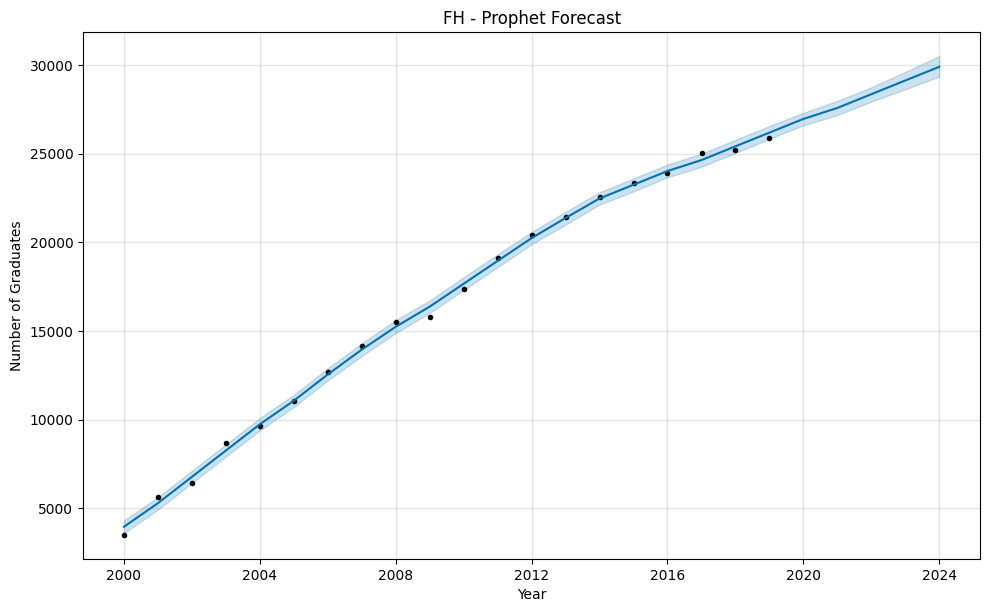

13:33:01 - cmdstanpy - INFO - Chain [1] start processing
13:33:01 - cmdstanpy - INFO - Chain [1] done processing


FH - Predicted total graduates in 2024: 29896.06
FH - Number of periods in original grouped data: 24
FH - Number of training periods: 20
FH - Number of test periods: 4
------------------------------
HS - Test RMSE: 1409.47
HS - Test R-squared: -0.11


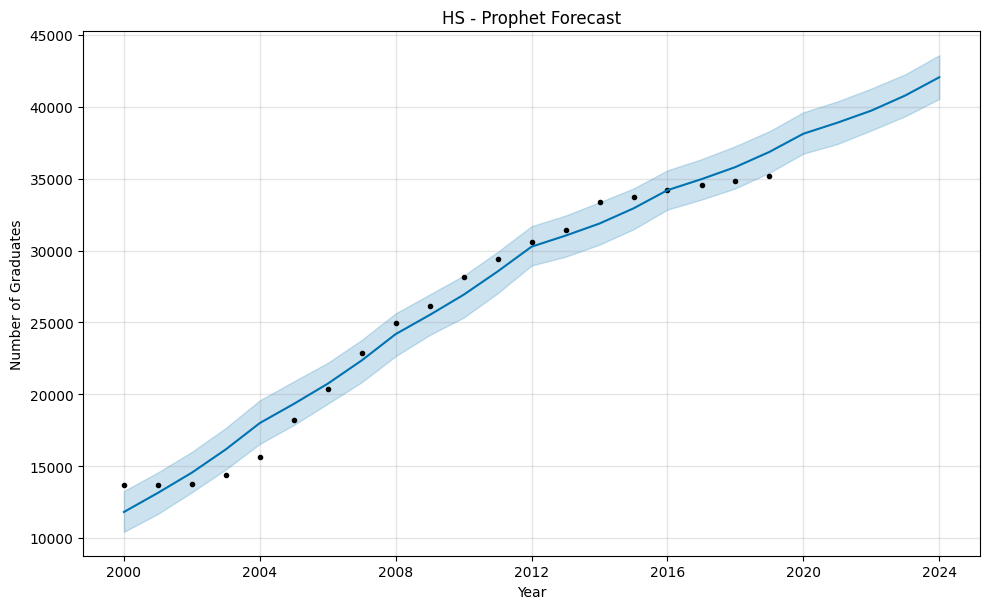

HS - Predicted total graduates in 2024: 42052.17
HS - Number of periods in original grouped data: 24
HS - Number of training periods: 20
HS - Number of test periods: 4
------------------------------


In [32]:
# --- Prophet-Modell (Erweitert, FH und Universität) ---
# Dieses Code-Segment implementiert das Prophet-Modell zur Prognose der
# jährlichen Absolventenzahlen an Fachhochschulen (FH) und Universitäten.
# - Eine Funktion (prophet_model) wird definiert, um den Code wiederverwendbar zu machen.
# - Die Daten werden nach Hochschultyp (FH, Universität) gefiltert und jährlich aggregiert.
#   - WICHTIG: Zeitraum (2000-2023) wird VOR der Gruppierung korrekt gefiltert.
# - Konvertierung der Jahreszahlen in datetime-Objekte (Spalten 'ds' und 'y').
# - Aufteilung in Trainings- und Testdatensätze: 85/15 (chronologische Reihenfolge).
# - Prophet-Modell wird mit Standardeinstellungen initialisiert und trainiert.
# - Vorhersage für die Testdaten und das Jahr 2024.
# - Ausgabe: RMSE, R-squared, Vorhersage für 2024 und Diagramme.
# - Die Funktion wird für FH und Universität getrennt aufgerufen.

import pandas as pd
import sqlite3
import os
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Define folder paths
output_folder = "output"
db_path = os.path.join(output_folder, "abschluesse.db")

# --- Data Loading ---
conn = sqlite3.connect(db_path)
query = "SELECT period_id, university_type_id, value FROM Graduations;"
df = pd.read_sql_query(query, conn)
conn.close()

# --- Function for Prophet Modeling ---
def prophet_model(df, university_type_id, output_prefix=""):
    """
    Applies the Prophet model to a subset of the data.

    Args:
        df (pd.DataFrame): The input DataFrame.
        university_type_id (int): The university type ID to filter on.
        output_prefix (str): Prefix for plot titles and print statements.

    Returns:
        None
    """

    df_filtered = df[df['university_type_id'] == university_type_id]

    # --- CRITICAL FIX: Filter BEFORE grouping ---
    # Map period_ids to years *before* grouping
    df_filtered = df_filtered.copy()  # Avoid SettingWithCopyWarning
    df_filtered['year'] = df_filtered['period_id'].apply(lambda x: 2000 + (x - 21))
    # Filter for the correct timeframe *before* grouping
    df_filtered = df_filtered[(df_filtered['year'] >= 2000) & (df_filtered['year'] <= 2023)]

    df_grouped = df_filtered.groupby('period_id')['value'].sum().reset_index()


    # --- Data Preparation for Prophet ---
    df_prophet = df_grouped[['period_id', 'value']].copy()
    df_prophet.columns = ['ds', 'y']
    # Now, period_id is already filtered, so we can map to year
    df_prophet['ds'] = df_prophet['ds'].apply(lambda x: 2000 + (x - 21))
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')


    # --- Split into Train and Test Sets ---
    train_size = int(len(df_prophet) * 0.85)
    train_data = df_prophet[:train_size]
    test_data = df_prophet[train_size:]

    # --- Model Initialization and Training ---
    model = Prophet()
    model.fit(train_data)

    # --- Forecasting ---
    future = model.make_future_dataframe(periods=len(test_data) + 1, freq='YS')
    forecast = model.predict(future)

    # --- Evaluation ---
    forecast_test = forecast[train_size:len(df_prophet)]
    comparison = pd.merge(test_data, forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='inner')

    # Calculate RMSE und R2
    rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
    print(f'{output_prefix}Test RMSE: {rmse:.2f}')
    r2 = r2_score(comparison['y'], comparison['yhat'])
    print(f'{output_prefix}Test R-squared: {r2:.2f}')

    # --- Plotting ---
    fig1 = model.plot(forecast)
    plt.title(f"{output_prefix}Prophet Forecast")
    plt.xlabel("Year")
    plt.ylabel("Number of Graduates")
    plt.show()

    # REMOVED: fig2 = model.plot_components(forecast)

    # --- Prediction for 2024 ---
    pred_2024 = forecast.loc[forecast['ds'] == '2024-01-01', 'yhat'].values[0]
    print(f"{output_prefix}Predicted total graduates in 2024: {pred_2024:.2f}")

    # --- Display Data Split ---
    print(f"{output_prefix}Number of periods in original grouped data: {len(df_grouped)}")
    print(f"{output_prefix}Number of training periods: {len(train_data)}")
    print(f"{output_prefix}Number of test periods: {len(test_data)}")
    print("-" * 30)

# --- Apply the function for each university type ---
prophet_model(df, university_type_id=1, output_prefix="FH - ")
prophet_model(df, university_type_id=2, output_prefix="HS - ")

13:33:01 - cmdstanpy - INFO - Chain [1] start processing
13:33:01 - cmdstanpy - INFO - Chain [1] done processing
13:33:01 - cmdstanpy - INFO - Chain [1] start processing
13:33:01 - cmdstanpy - INFO - Chain [1] done processing
13:33:01 - cmdstanpy - INFO - Chain [1] start processing
13:33:01 - cmdstanpy - INFO - Chain [1] done processing
13:33:02 - cmdstanpy - INFO - Chain [1] start processing
13:33:02 - cmdstanpy - INFO - Chain [1] done processing
13:33:02 - cmdstanpy - INFO - Chain [1] start processing
13:33:02 - cmdstanpy - INFO - Chain [1] done processing
13:33:02 - cmdstanpy - INFO - Chain [1] start processing
13:33:02 - cmdstanpy - INFO - Chain [1] done processing
13:33:02 - cmdstanpy - INFO - Chain [1] start processing
13:33:02 - cmdstanpy - INFO - Chain [1] done processing


RMSE scores for each fold (FH): [468.63064254 468.00643901 393.27564063 702.20681888 257.40518593]
Mean RMSE (FH): 457.90
Standard Deviation of RMSE (FH): 144.41
R2 scores for each fold (FH): [0.99637293 0.99624037 0.99667363 0.98171222 0.99738117]
Mean R2 (FH): 0.99
Standard Deviation of R2 (FH): 0.01
Predicted total graduates for FH in 2024: 28965.16


13:33:02 - cmdstanpy - INFO - Chain [1] start processing
13:33:02 - cmdstanpy - INFO - Chain [1] done processing
13:33:02 - cmdstanpy - INFO - Chain [1] start processing
13:33:02 - cmdstanpy - INFO - Chain [1] done processing
13:33:02 - cmdstanpy - INFO - Chain [1] start processing
13:33:02 - cmdstanpy - INFO - Chain [1] done processing
13:33:02 - cmdstanpy - INFO - Chain [1] start processing
13:33:02 - cmdstanpy - INFO - Chain [1] done processing
13:33:02 - cmdstanpy - INFO - Chain [1] start processing
13:33:02 - cmdstanpy - INFO - Chain [1] done processing


RMSE scores for each fold (HS): [2076.92416832  648.13723761 2105.00059438  961.16403077 1256.9560762 ]
Mean RMSE (HS): 1409.64
Standard Deviation of RMSE (HS): 588.75
R2 scores for each fold (HS): [0.92812063 0.99448664 0.94148393 0.97461106 0.95205897]
Mean R2 (HS): 0.96
Standard Deviation of R2 (HS): 0.02
Predicted total graduates for HS in 2024: 40461.56


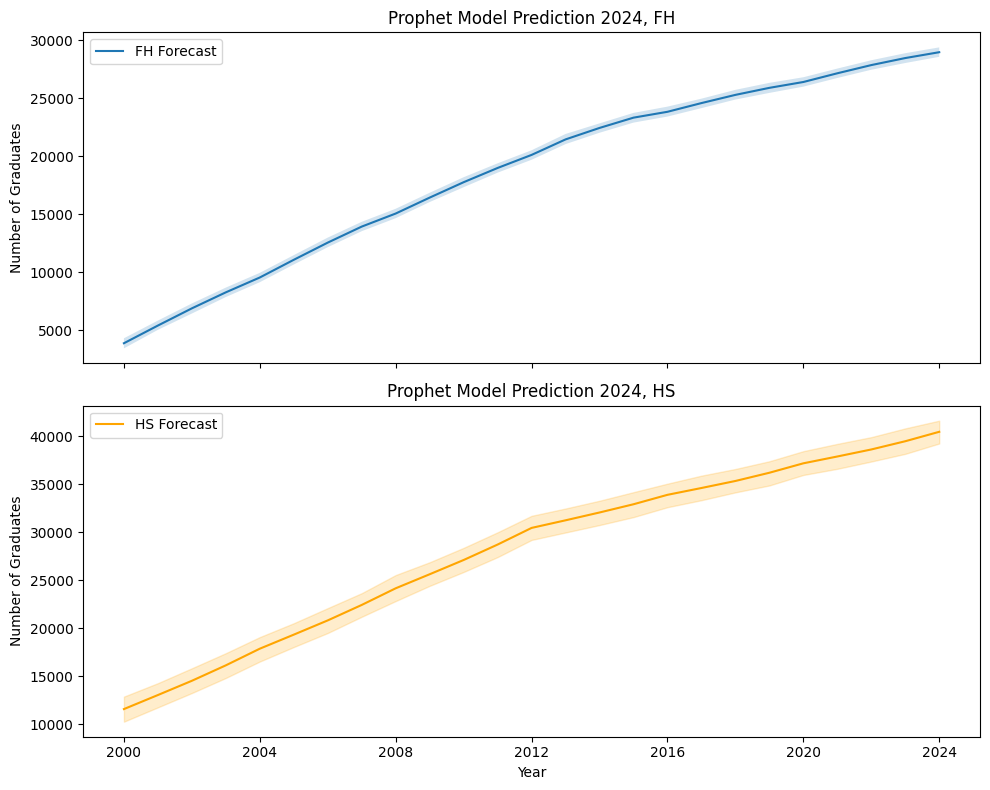


--- Zusammenfassung der Ergebnisse ---
FH - Mean RMSE: 457.90, Mean R²: 0.99, Prediction 2024: 28965.16
HS - Mean RMSE: 1409.64, Mean R²: 0.96, Prediction 2024: 40461.56


In [33]:
# --- Prophet-Modell mit Kreuzvalidierung (FH und Universität) ---
# Dieses Code-Segment implementiert das Prophet-Modell zur Prognose der
# jährlichen Absolventenzahlen an Fachhochschulen (FH) und Universitäten (HS).
# Es wird eine k-fache Kreuzvalidierung durchgeführt, um die Modellgüte zu bewerten.
# - Eine Funktion (run_cross_validation) führt die Kreuzvalidierung durch.
# - Daten werden nach Hochschultyp gefiltert und jährlich aggregiert. - Zeitraum: 2000-2023
# - Konvertierung der Jahreszahlen in datetime-Objekte ('ds', 'y' Spalten).
# - k-fache Kreuzvalidierung (k=5, mit Mischen der Daten).
# - Berechnung von RMSE und R² für jede Falte.
# - Behandlung von leeren Vergleichs-DataFrames (NaN-Werte).
# - Ausgabe: RMSE, R², Vorhersage für 2024 je Hochschultyp, und Plots.
# - Vorhersage für 2024 wird mit dem *letzten* trainierten Modell erstellt.
# - Ergebnisse der Kreuzvalidierung und die Vorhersage für 2024

import pandas as pd
import sqlite3
import os
from prophet import Prophet
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Define folder paths
output_folder = "output"
db_path = os.path.join(output_folder, "abschluesse.db")

# --- Data Loading ---
conn = sqlite3.connect(db_path)
query = "SELECT period_id, university_type_id, value FROM Graduations;"
df = pd.read_sql_query(query, conn)
conn.close()

# --- Funktion für die Kreuzvalidierung ---
def run_cross_validation(df, university_type_id, type_name):
    """
    Führt eine k-fache Kreuzvalidierung für das Prophet-Modell durch.

    Args:
        df: DataFrame mit den Daten.
        university_type_id: ID des Hochschultyps (1 für FH, 2 für HS).
        type_name:  String-Bezeichnung des Hochschultyps ("FH" oder "HS").

    Returns:
        Tuple: (Gemittelter RMSE, Gemitteltes R², Vorhersage für 2024)
    """

    df_type = df[df['university_type_id'] == university_type_id].copy()

    # --- Vorbereitung ---
    df_type['year'] = df_type['period_id'].apply(lambda x: 2000 + (x - 21))
    df_type = df_type[(df_type['year'] >= 2000) & (df_type['year'] <= 2023)]
    df_grouped = df_type.groupby('year')['value'].sum().reset_index()

    df_prophet = df_grouped[['year', 'value']].copy()
    df_prophet.columns = ['ds', 'y']
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

    # --- k-fache Kreuzvalidierung ---
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    r2_scores = []

    for train_index, test_index in kf.split(df_prophet):
        train_data = df_prophet.iloc[train_index]
        test_data = df_prophet.iloc[test_index]

        model = Prophet()
        model.fit(train_data)
        forecast = model.predict(test_data)

        comparison = pd.merge(test_data, forecast[['ds', 'yhat']], on='ds', how='inner')

        if comparison.empty:
            print(f"Vergleichs-DataFrame ist leer für {type_name}. Überspringe RMSE/R2-Berechnung für diese Falte.")
            rmse = np.nan
            r2 = np.nan
        else:
            rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
            r2 = r2_score(comparison['y'], comparison['yhat'])

        rmse_scores.append(rmse)
        r2_scores.append(r2)

    rmse_scores = np.array(rmse_scores)
    r2_scores = np.array(r2_scores)

    mean_rmse = np.nanmean(rmse_scores)
    mean_r2 = np.nanmean(r2_scores)

    rmse_scores = np.nan_to_num(rmse_scores, nan=mean_rmse)  # Ersetze NaN durch den Mittelwert
    r2_scores = np.nan_to_num(r2_scores, nan=mean_r2)


    print(f"RMSE scores for each fold ({type_name}): {rmse_scores}")
    print(f"Mean RMSE ({type_name}): {np.mean(rmse_scores):.2f}")
    print(f"Standard Deviation of RMSE ({type_name}): {np.std(rmse_scores):.2f}")
    print(f"R2 scores for each fold ({type_name}): {r2_scores}")
    print(f"Mean R2 ({type_name}): {np.mean(r2_scores):.2f}")
    print(f"Standard Deviation of R2 ({type_name}): {np.std(r2_scores):.2f}")

    # --- Vorhersage für 2024 (mit dem LETZTEN Modell) ---
    final_model = Prophet()
    final_model.fit(df_prophet)
    future = final_model.make_future_dataframe(periods=1, freq='YS')
    forecast = final_model.predict(future)
    pred_2024 = forecast.loc[forecast['ds'] == '2024-01-01', 'yhat'].values[0]
    print(f"Predicted total graduates for {type_name} in 2024: {pred_2024:.2f}")

    return mean_rmse, mean_r2, pred_2024, final_model, forecast

# --- Hauptprogramm ---

# Kreuzvalidierung und Vorhersage für FH
mean_rmse_fh, mean_r2_fh, pred_2024_fh, model_fh, forecast_fh = run_cross_validation(df, 1, "FH")

# Kreuzvalidierung und Vorhersage für HS
mean_rmse_hs, mean_r2_hs, pred_2024_hs, model_hs, forecast_hs = run_cross_validation(df, 2, "HS")

# --- Plotting (beide Hochschultypen) ---
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot für FH
axes[0].plot(forecast_fh['ds'], forecast_fh['yhat'], label='FH Forecast')
axes[0].fill_between(forecast_fh['ds'], forecast_fh['yhat_lower'], forecast_fh['yhat_upper'], alpha=0.2)
axes[0].set_title('Prophet Model Prediction 2024, FH')
axes[0].set_ylabel('Number of Graduates')
axes[0].legend()

# Plot für HS
axes[1].plot(forecast_hs['ds'], forecast_hs['yhat'], label='HS Forecast', color='orange')
axes[1].fill_between(forecast_hs['ds'], forecast_hs['yhat_lower'], forecast_hs['yhat_upper'], alpha=0.2, color='orange')
axes[1].set_title('Prophet Model Prediction 2024, HS')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Graduates')
axes[1].legend()

plt.tight_layout()
plt.show()
#---Text-Output zur besseren Darstellung---
print("\n--- Zusammenfassung der Ergebnisse ---")
print(f"FH - Mean RMSE: {mean_rmse_fh:.2f}, Mean R²: {mean_r2_fh:.2f}, Prediction 2024: {pred_2024_fh:.2f}")
print(f"HS - Mean RMSE: {mean_rmse_hs:.2f}, Mean R²: {mean_r2_hs:.2f}, Prediction 2024: {pred_2024_hs:.2f}")